In [1]:
import torch
import torch.optim as optim
from torch.optim import Adam, lr_scheduler
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from transformers import ViTForImageClassification, ViTImageProcessor
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import os
import glob
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch.nn as nn
import json
import torch.nn.functional as F
import copy
import time

# ***Data Preprocessing***

In [2]:
ROOT_DIR = '/kaggle/input/new-plantvillage/new_PlantVillage'
TRAIN_PATH = '/kaggle/working/train_images'
VALIDATION_PATH = '/kaggle/working/validation_images'
TEST_PATH = '/kaggle/working/test_images'
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(VALIDATION_PATH, exist_ok=True)
os.makedirs(TEST_PATH, exist_ok=True)

def create_class_subdirs(base_path, class_names):
    for class_name in class_names:
        os.makedirs(os.path.join(base_path, class_name), exist_ok=True)

all_subdirs = [os.path.join(ROOT_DIR, subdir) for subdir in os.listdir(ROOT_DIR)]
class_names = sorted([os.path.basename(subdir) for subdir in all_subdirs if os.path.isdir(subdir)])
create_class_subdirs(TRAIN_PATH, class_names)
create_class_subdirs(VALIDATION_PATH, class_names)
create_class_subdirs(TEST_PATH, class_names)

all_images = []
image_labels = []
for subdir in all_subdirs:
    class_name = os.path.basename(subdir)
    # images = glob.glob(subdir + '/*.JPG')
    images = glob.glob(subdir + '/*.JPG') + glob.glob(subdir + '/*.jpg')
    all_images.extend(images)
    image_labels.extend([class_name] * len(images))

np.random.seed(42)
all_images = np.array(all_images)
image_labels = np.array(image_labels)

train_images, test_images, train_labels, test_labels = train_test_split(all_images, image_labels, test_size=0.2, stratify=image_labels, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=42)

def move_images(images, labels, base_path):
    for img_path, label in zip(images, labels):
        shutil.copy(img_path, os.path.join(base_path, label, os.path.basename(img_path)))

move_images(train_images, train_labels, TRAIN_PATH)
move_images(val_images, val_labels, VALIDATION_PATH)
move_images(test_images, test_labels, TEST_PATH)

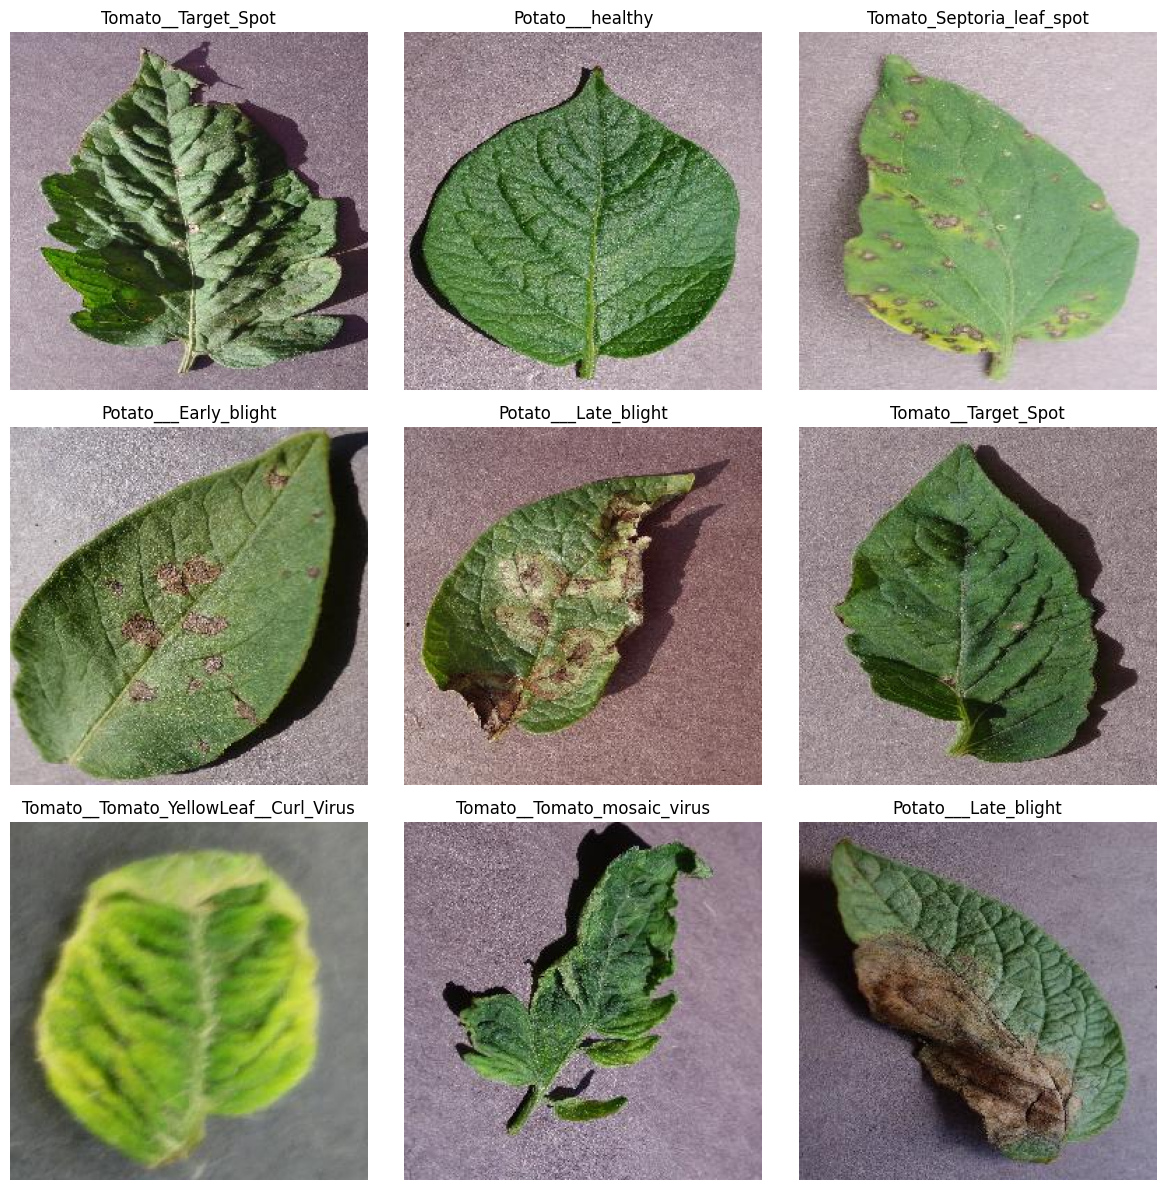

In [3]:
import matplotlib.pyplot as plt
import os
import random
import cv2

def display_plant_images(dataset_path, num_rows=3, num_cols=3, class_names=None):
    """
    Displays a grid of random images from specified plant disease classes.

    Args:
        dataset_path (str): Path to the main dataset directory.
        num_rows (int): Number of rows in the image grid.
        num_cols (int): Number of columns in the image grid.
        class_names (list, optional):  A list of class names to select from.
            If None, it will use all subdirectories in the `dataset_path`.
            Defaults to None.
    """

    if class_names is None:
        class_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))] # List only directories
    else:
        #validate class name existence
        valid_classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))] # List only directories

        for class_name in class_names:
          if class_name not in valid_classes:
            raise ValueError(f"Class {class_name} not found in directory {dataset_path}")



    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(num_rows * num_cols):
        class_name = random.choice(class_names) # selecting a class name

        class_path = os.path.join(dataset_path, class_name) # creating path of the class name
        image_files = os.listdir(class_path) # listing images of a class
        image_path = os.path.join(class_path, random.choice(image_files)) # selecting a image path of a class
        
        try:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            axes[i].imshow(img)
            axes[i].set_title(class_name)
            axes[i].axis('off')

        except Exception as e:
             print(f"Error processing image: {image_path} - {e}")
             axes[i].text(0.5, 0.5, "Error", ha="center", va="center", color="red")
             axes[i].axis('off')
             

    plt.tight_layout()
    plt.show()

# Example Usage (replace with your actual path)
dataset_path = "/kaggle/input/new-plantvillage/new_PlantVillage"  # or wherever your images are stored
classes = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Rice___Bacterialblight', 'Rice___Blast', 'Rice___Blight', 'Rice___Brownspot', 'Rice___Tungro', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']

display_plant_images(dataset_path, class_names=classes)

In [4]:
# # Paths
# dataset_path = '/kaggle/input/jute-leaf-disease-detection/Jute Leaf Disease Detection'
# output_path = '/kaggle/working/Jute_Leaf_YOLO'

# # Create YOLO folders
# os.makedirs(f'{output_path}/train/images', exist_ok=True)
# os.makedirs(f'{output_path}/train/labels', exist_ok=True)
# os.makedirs(f'{output_path}/val/images', exist_ok=True)
# os.makedirs(f'{output_path}/val/labels', exist_ok=True)

# # Class mapping
# class_names = ['Cescospora Leaf Spot', 'Golden Mosaic', 'Healthy Leaf']
# class_map = {name: i for i, name in enumerate(class_names)}

# # Process each class folder
# for class_name in class_names:
#     class_folder = os.path.join(dataset_path, class_name)
#     images = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.png'))]

#     # Split data into train and val (80-20 split)
#     train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

#     # Move files to respective YOLO folders
#     for img_set, set_type in [(train_imgs, 'train'), (val_imgs, 'val')]:
#         for img in img_set:
#             # Copy images
#             src = os.path.join(class_folder, img)
#             dst = os.path.join(output_path, set_type, 'images', img)
#             shutil.copy(src, dst)

#             # Generate YOLO-format label files
#             label_path = os.path.join(output_path, set_type, 'labels', img.replace('.jpg', '.txt').replace('.png', '.txt'))
#             with open(label_path, 'w') as f:
#                 class_id = class_map[class_name]
#                 # Dummy annotation: Replace with actual bounding box data
#                 f.write(f'{class_id} 0.5 0.5 0.5 0.5\n')  # Replace with actual bounding box info

# # Create a data.yaml file for YOLO training
# data_yaml_path = os.path.join(output_path, 'data.yaml')
# with open(data_yaml_path, 'w') as f:
#     f.write(f"""train: {output_path}/train/images
# val: {output_path}/val/images

# nc: {len(class_names)}
# names: {class_names}
# """)

# print(f"Dataset is ready for YOLO training. 'data.yaml' created at {data_yaml_path}.")


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


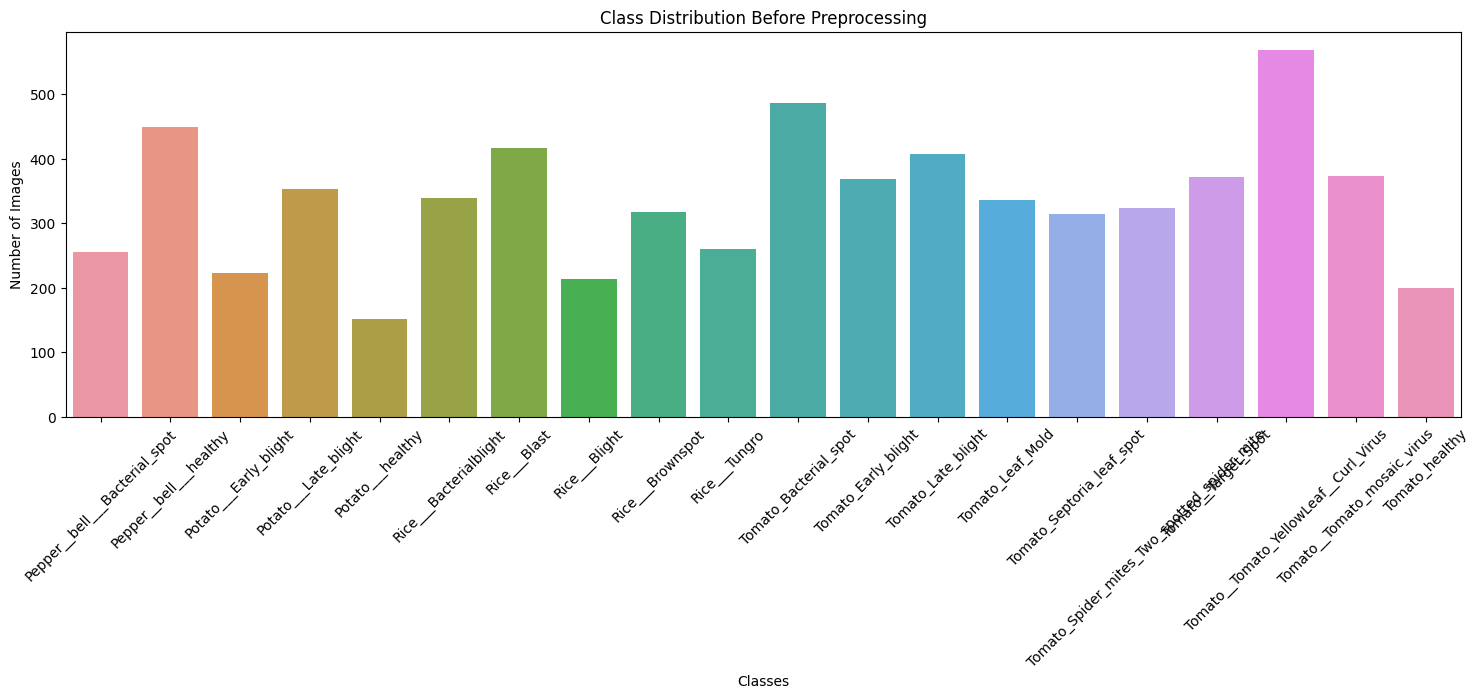

In [5]:
def plot_class_distribution(labels, title="Class Distribution"):
    class_counts = Counter(labels)
    keys, values = zip(*sorted(class_counts.items()))  # Sort keys and values
    plt.figure(figsize=(18, 5))
    sns.barplot(x=list(keys), y=list(values))
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()


all_images = []
all_labels = []
for subdir in all_subdirs:
    class_name = os.path.basename(subdir)
    images = glob.glob(subdir + '/*.JPG') + glob.glob(subdir + '/*.jpg')
    all_images.extend(images)
    all_labels.extend([class_name] * len(images))


plot_class_distribution(all_labels, title="Class Distribution Before Preprocessing")

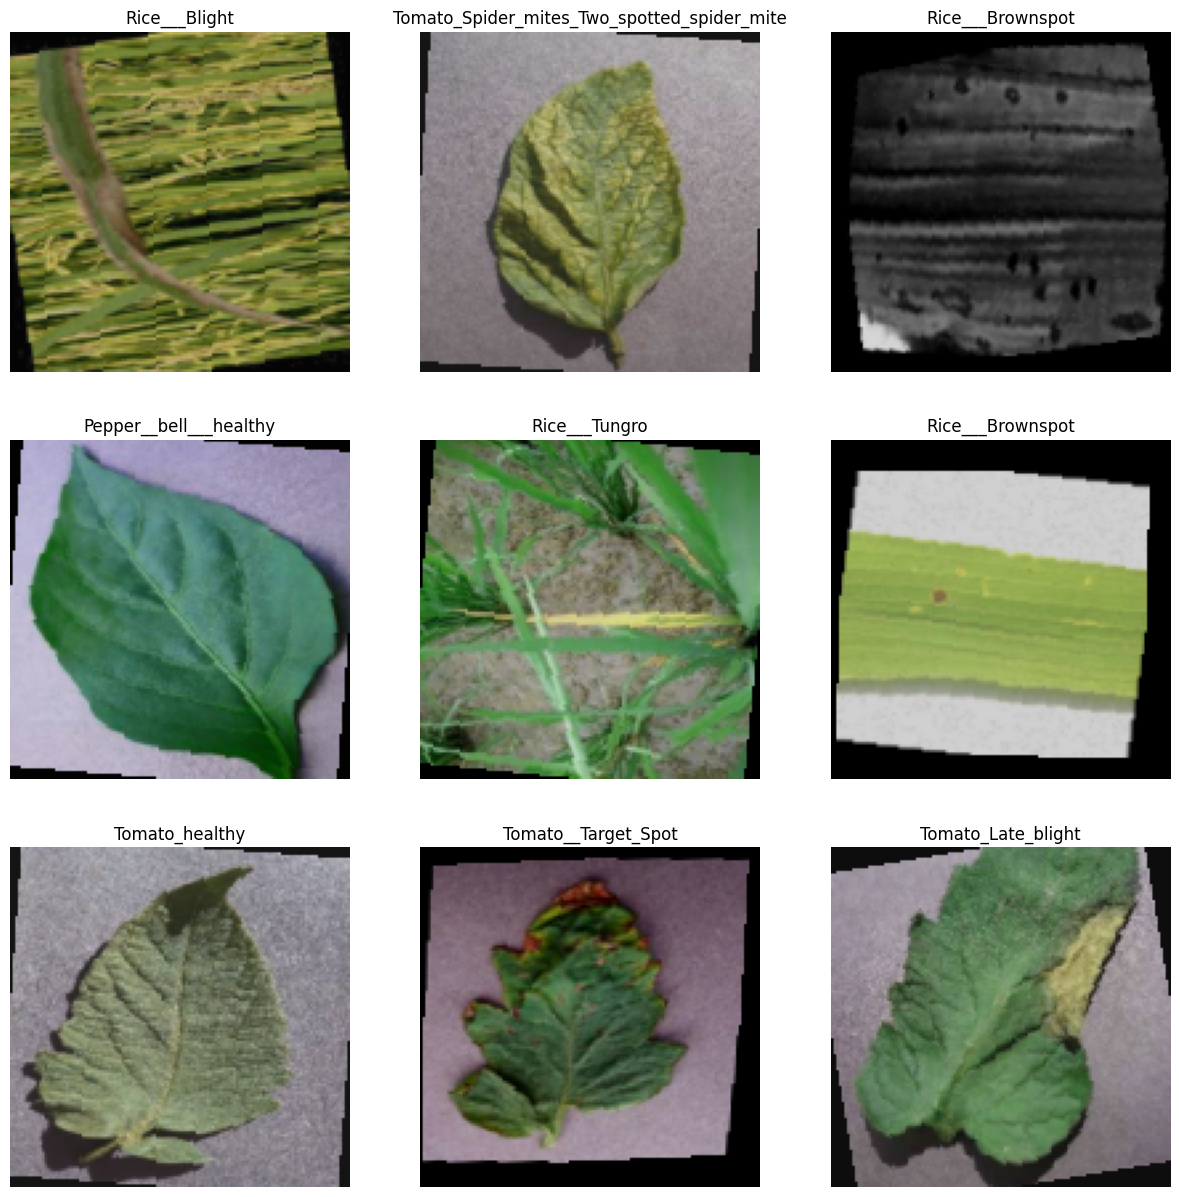

In [6]:
# ROOT_DIR = '/kaggle/input/jute-leaf-disease-detection/Jute Leaf Disease Detection'
# TRAIN_PATH = '/kaggle/working/Jute_Leaf_YOLO/train'
# TEST_PATH = '/kaggle/working/Jute_Leaf_YOLO/val'

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.2),  # Adding more augmentation
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Adding more augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=train_transform)
val_dataset = datasets.ImageFolder(root=VALIDATION_PATH, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=TEST_PATH, transform=val_test_transform)

import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import random

# Assuming your datasets and transforms are defined as in your previous code

def show_random_images(dataset, class_names, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Create a 3x3 grid of subplots
    axes = axes.ravel()  # Flatten the 2D array of axes to make it easier to iterate over
    random_indices = random.sample(range(len(dataset)), num_images)  # Randomly select image indices

    for i in range(num_images):
        img, label = dataset[random_indices[i]]
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        img = img.numpy()

        axes[i].imshow(img)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.show()

# Call the function to display random 3x3 grid of images
show_random_images(train_dataset, train_dataset.classes)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


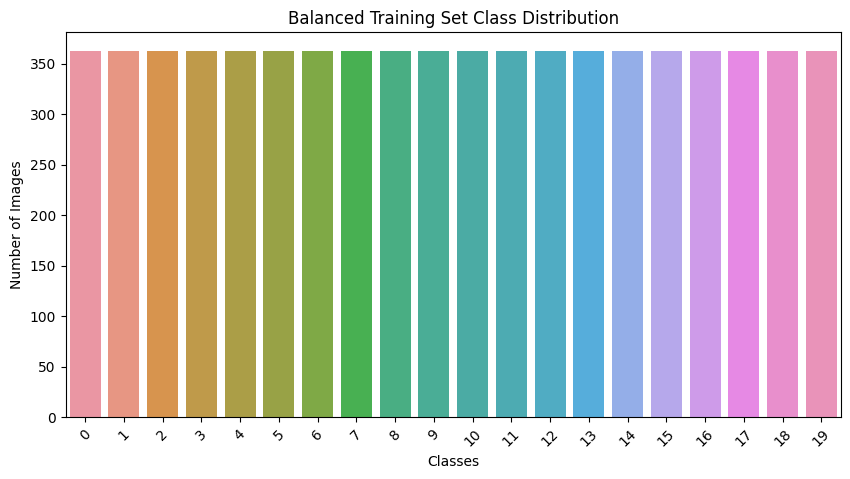

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


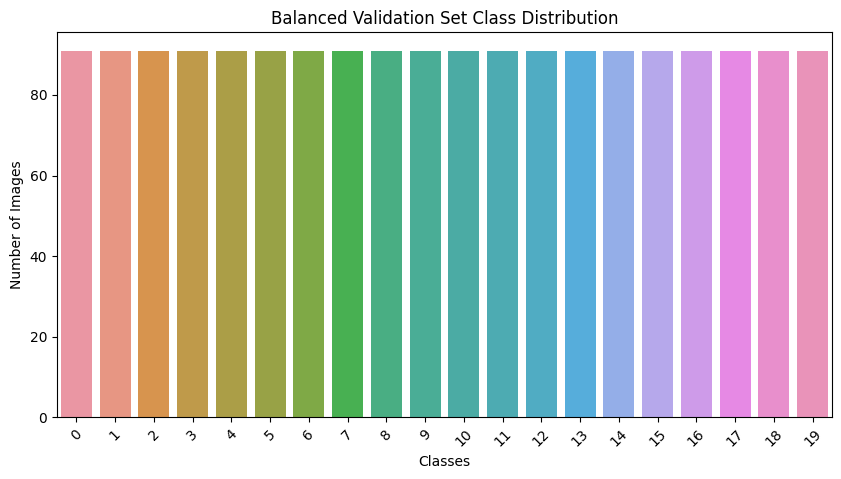

In [7]:
def plot_class_distribution(labels, title="Class Distribution"):
    class_counts = Counter(labels)
    keys, values = zip(*sorted(class_counts.items()))  # Sort keys and values
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(keys), y=list(values))
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

def balance_dataset(images, labels):
    class_counts = Counter(labels)
    max_count = max(class_counts.values())

    new_images = []
    new_labels = []

    for class_idx in np.unique(labels):
        class_images = [img for img, label in zip(images, labels) if label == class_idx]
        oversample_count = max_count - len(class_images)
        oversampled_images = np.random.choice(class_images, oversample_count, replace=True)

        new_images.extend(class_images + list(oversampled_images))
        new_labels.extend([class_idx] * (len(class_images) + oversample_count))

    return new_images, new_labels

train_images = [img_path for img_path, _ in train_dataset.samples]
train_labels = [label for _, label in train_dataset.samples]

val_images = [img_path for img_path, _ in val_dataset.samples]
val_labels = [label for _, label in val_dataset.samples]

balanced_train_images, balanced_train_labels = balance_dataset(train_images, train_labels)
balanced_val_images, balanced_val_labels = balance_dataset(val_images, val_labels)

plot_class_distribution(balanced_train_labels, title="Balanced Training Set Class Distribution")
plot_class_distribution(balanced_val_labels, title="Balanced Validation Set Class Distribution")

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = datasets.folder.default_loader(self.image_paths[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

balanced_train_dataset = CustomImageDataset(balanced_train_images, balanced_train_labels, transform=train_transform)
balanced_val_dataset = CustomImageDataset(balanced_val_images, balanced_val_labels, transform=val_test_transform)

In [8]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 17.3 MB/s eta 0:00:0000:01


In [9]:
!pip install torchsummary

# ***Creating custom model and evaluating without knowledge Distillation***

# YOLO11 from scratch

In [10]:
#UTILITY

import copy
import random
from time import time

import math
import numpy
import torch
import torchvision
from torch.nn.functional import cross_entropy


def setup_seed():
    """
    Setup random seed.
    """
    random.seed(0)
    numpy.random.seed(0)
    torch.manual_seed(0)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


def setup_multi_processes():
    """
    Setup multi-processing environment variables.
    """
    import cv2
    from os import environ
    from platform import system

    # set multiprocess start method as `fork` to speed up the training
    if system() != 'Windows':
        torch.multiprocessing.set_start_method('fork', force=True)

    # disable opencv multithreading to avoid system being overloaded
    cv2.setNumThreads(0)

    # setup OMP threads
    if 'OMP_NUM_THREADS' not in environ:
        environ['OMP_NUM_THREADS'] = '1'

    # setup MKL threads
    if 'MKL_NUM_THREADS' not in environ:
        environ['MKL_NUM_THREADS'] = '1'


def export_onnx(args):
    import onnx  # noqa

    inputs = ['images']
    outputs = ['outputs']
    dynamic = {'outputs': {0: 'batch', 1: 'anchors'}}

    m = torch.load('./weights/best.pt')['model'].float()
    x = torch.zeros((1, 3, args.input_size, args.input_size))

    torch.onnx.export(m.cpu(), x.cpu(),
                      f='./weights/best.onnx',
                      verbose=False,
                      opset_version=12,
                      # WARNING: DNN inference with torch>=1.12 may require do_constant_folding=False
                      do_constant_folding=True,
                      input_names=inputs,
                      output_names=outputs,
                      dynamic_axes=dynamic or None)

    # Checks
    model_onnx = onnx.load('./weights/best.onnx')  # load onnx model
    onnx.checker.check_model(model_onnx)  # check onnx model

    onnx.save(model_onnx, './weights/best.onnx')
    # Inference example
    # https://github.com/ultralytics/ultralytics/blob/main/ultralytics/nn/autobackend.py


def wh2xy(x):
    y = x.clone() if isinstance(x, torch.Tensor) else numpy.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y


def make_anchors(x, strides, offset=0.5):
    assert x is not None
    anchor_tensor, stride_tensor = [], []
    dtype, device = x[0].dtype, x[0].device
    for i, stride in enumerate(strides):
        _, _, h, w = x[i].shape
        sx = torch.arange(end=w, device=device, dtype=dtype) + offset  # shift x
        sy = torch.arange(end=h, device=device, dtype=dtype) + offset  # shift y
        sy, sx = torch.meshgrid(sy, sx)
        anchor_tensor.append(torch.stack((sx, sy), -1).view(-1, 2))
        stride_tensor.append(torch.full((h * w, 1), stride, dtype=dtype, device=device))
    return torch.cat(anchor_tensor), torch.cat(stride_tensor)


def compute_metric(output, target, iou_v):
    # intersection(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    (a1, a2) = target[:, 1:].unsqueeze(1).chunk(2, 2)
    (b1, b2) = output[:, :4].unsqueeze(0).chunk(2, 2)
    intersection = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)
    # IoU = intersection / (area1 + area2 - intersection)
    iou = intersection / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - intersection + 1e-7)

    correct = numpy.zeros((output.shape[0], iou_v.shape[0]))
    correct = correct.astype(bool)
    for i in range(len(iou_v)):
        # IoU > threshold and classes match
        x = torch.where((iou >= iou_v[i]) & (target[:, 0:1] == output[:, 5]))
        if x[0].shape[0]:
            matches = torch.cat((torch.stack(x, 1),
                                 iou[x[0], x[1]][:, None]), 1).cpu().numpy()  # [label, detect, iou]
            if x[0].shape[0] > 1:
                matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[numpy.unique(matches[:, 1], return_index=True)[1]]
                matches = matches[numpy.unique(matches[:, 0], return_index=True)[1]]
            correct[matches[:, 1].astype(int), i] = True
    return torch.tensor(correct, dtype=torch.bool, device=output.device)


def non_max_suppression(outputs, confidence_threshold=0.001, iou_threshold=0.65):
    max_wh = 7680
    max_det = 300
    max_nms = 30000

    bs = outputs.shape[0]  # batch size
    nc = outputs.shape[1] - 4  # number of classes
    xc = outputs[:, 4:4 + nc].amax(1) > confidence_threshold  # candidates

    # Settings
    start = time()
    limit = 0.5 + 0.05 * bs  # seconds to quit after
    output = [torch.zeros((0, 6), device=outputs.device)] * bs
    for index, x in enumerate(outputs):  # image index, image inference
        x = x.transpose(0, -1)[xc[index]]  # confidence

        # If none remain process next image
        if not x.shape[0]:
            continue

        # matrix nx6 (box, confidence, cls)
        box, cls = x.split((4, nc), 1)
        box = wh2xy(box)  # (cx, cy, w, h) to (x1, y1, x2, y2)
        if nc > 1:
            i, j = (cls > confidence_threshold).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, 4 + j, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = cls.max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > confidence_threshold]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence and remove excess boxes

        # Batched NMS
        c = x[:, 5:6] * max_wh  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes, scores
        indices = torchvision.ops.nms(boxes, scores, iou_threshold)  # NMS
        indices = indices[:max_det]  # limit detections

        output[index] = x[indices]
        if (time() - start) > limit:
            break  # time limit exceeded

    return output


def smooth(y, f=0.1):
    # Box filter of fraction f
    nf = round(len(y) * f * 2) // 2 + 1  # number of filter elements (must be odd)
    p = numpy.ones(nf // 2)  # ones padding
    yp = numpy.concatenate((p * y[0], y, p * y[-1]), 0)  # y padded
    return numpy.convolve(yp, numpy.ones(nf) / nf, mode='valid')  # y-smoothed


def plot_pr_curve(px, py, ap, names, save_dir):
    from matplotlib import pyplot
    fig, ax = pyplot.subplots(1, 1, figsize=(9, 6), tight_layout=True)
    py = numpy.stack(py, axis=1)

    if 0 < len(names) < 21:  # display per-class legend if < 21 classes
        for i, y in enumerate(py.T):
            ax.plot(px, y, linewidth=1, label=f"{names[i]} {ap[i, 0]:.3f}")  # plot(recall, precision)
    else:
        ax.plot(px, py, linewidth=1, color="grey")  # plot(recall, precision)

    ax.plot(px, py.mean(1), linewidth=3, color="blue", label="all classes %.3f mAP@0.5" % ap[:, 0].mean())
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    ax.set_title("Precision-Recall Curve")
    fig.savefig(save_dir, dpi=250)
    pyplot.close(fig)


def plot_curve(px, py, names, save_dir, x_label="Confidence", y_label="Metric"):
    from matplotlib import pyplot

    figure, ax = pyplot.subplots(1, 1, figsize=(9, 6), tight_layout=True)

    if 0 < len(names) < 21:  # display per-class legend if < 21 classes
        for i, y in enumerate(py):
            ax.plot(px, y, linewidth=1, label=f"{names[i]}")  # plot(confidence, metric)
    else:
        ax.plot(px, py.T, linewidth=1, color="grey")  # plot(confidence, metric)

    y = smooth(py.mean(0), f=0.05)
    ax.plot(px, y, linewidth=3, color="blue", label=f"all classes {y.max():.3f} at {px[y.argmax()]:.3f}")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    ax.set_title(f"{y_label}-Confidence Curve")
    figure.savefig(save_dir, dpi=250)
    pyplot.close(figure)


def compute_ap(tp, conf, output, target, plot=False, names=(), eps=1E-16):
    """
    Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:  True positives (nparray, nx1 or nx10).
        conf:  Object-ness value from 0-1 (nparray).
        output:  Predicted object classes (nparray).
        target:  True object classes (nparray).
    # Returns
        The average precision
    """
    # Sort by object-ness
    i = numpy.argsort(-conf)
    tp, conf, output = tp[i], conf[i], output[i]

    # Find unique classes
    unique_classes, nt = numpy.unique(target, return_counts=True)
    nc = unique_classes.shape[0]  # number of classes, number of detections

    # Create Precision-Recall curve and compute AP for each class
    p = numpy.zeros((nc, 1000))
    r = numpy.zeros((nc, 1000))
    ap = numpy.zeros((nc, tp.shape[1]))
    px, py = numpy.linspace(start=0, stop=1, num=1000), []  # for plotting
    for ci, c in enumerate(unique_classes):
        i = output == c
        nl = nt[ci]  # number of labels
        no = i.sum()  # number of outputs
        if no == 0 or nl == 0:
            continue

        # Accumulate FPs and TPs
        fpc = (1 - tp[i]).cumsum(0)
        tpc = tp[i].cumsum(0)

        # Recall
        recall = tpc / (nl + eps)  # recall curve
        # negative x, xp because xp decreases
        r[ci] = numpy.interp(-px, -conf[i], recall[:, 0], left=0)

        # Precision
        precision = tpc / (tpc + fpc)  # precision curve
        p[ci] = numpy.interp(-px, -conf[i], precision[:, 0], left=1)  # p at pr_score

        # AP from recall-precision curve
        for j in range(tp.shape[1]):
            m_rec = numpy.concatenate(([0.0], recall[:, j], [1.0]))
            m_pre = numpy.concatenate(([1.0], precision[:, j], [0.0]))

            # Compute the precision envelope
            m_pre = numpy.flip(numpy.maximum.accumulate(numpy.flip(m_pre)))

            # Integrate area under curve
            x = numpy.linspace(start=0, stop=1, num=101)  # 101-point interp (COCO)
            ap[ci, j] = numpy.trapz(numpy.interp(x, m_rec, m_pre), x)  # integrate
            if plot and j == 0:
                py.append(numpy.interp(px, m_rec, m_pre))  # precision at mAP@0.5

    # Compute F1 (harmonic mean of precision and recall)
    f1 = 2 * p * r / (p + r + eps)
    if plot:
        names = dict(enumerate(names))  # to dict
        names = [v for k, v in names.items() if k in unique_classes]  # list: only classes that have data
        plot_pr_curve(px, py, ap, names, save_dir="./weights/PR_curve.png")
        plot_curve(px, f1, names, save_dir="./weights/F1_curve.png", y_label="F1")
        plot_curve(px, p, names, save_dir="./weights/P_curve.png", y_label="Precision")
        plot_curve(px, r, names, save_dir="./weights/R_curve.png", y_label="Recall")
    i = smooth(f1.mean(0), 0.1).argmax()  # max F1 index
    p, r, f1 = p[:, i], r[:, i], f1[:, i]
    tp = (r * nt).round()  # true positives
    fp = (tp / (p + eps) - tp).round()  # false positives
    ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
    m_pre, m_rec = p.mean(), r.mean()
    map50, mean_ap = ap50.mean(), ap.mean()
    return tp, fp, m_pre, m_rec, map50, mean_ap


def compute_iou(box1, box2, eps=1e-7):
    # Returns Intersection over Union (IoU) of box1(1,4) to box2(n,4)

    # Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1.chunk(4, -1)
    b2_x1, b2_y1, b2_x2, b2_y2 = box2.chunk(4, -1)
    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps

    # Intersection area
    inter = (b1_x2.minimum(b2_x2) - b1_x1.maximum(b2_x1)).clamp(0) * \
            (b1_y2.minimum(b2_y2) - b1_y1.maximum(b2_y1)).clamp(0)

    # Union Area
    union = w1 * h1 + w2 * h2 - inter + eps

    # IoU
    iou = inter / union
    cw = b1_x2.maximum(b2_x2) - b1_x1.minimum(b2_x1)  # convex (smallest enclosing box) width
    ch = b1_y2.maximum(b2_y2) - b1_y1.minimum(b2_y1)  # convex height
    c2 = cw ** 2 + ch ** 2 + eps  # convex diagonal squared
    rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 + (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4  # center dist ** 2
    # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
    v = (4 / math.pi ** 2) * (torch.atan(w2 / h2) - torch.atan(w1 / h1)).pow(2)
    with torch.no_grad():
        alpha = v / (v - iou + (1 + eps))
    return iou - (rho2 / c2 + v * alpha)  # CIoU


def strip_optimizer(filename):
    x = torch.load(filename, map_location="cpu")
    x['model'].half()  # to FP16
    for p in x['model'].parameters():
        p.requires_grad = False
    torch.save(x, f=filename)


def clip_gradients(model, max_norm=10.0):
    parameters = model.parameters()
    torch.nn.utils.clip_grad_norm_(parameters, max_norm=max_norm)


def load_weight(model, ckpt):
    dst = model.state_dict()
    src = torch.load(ckpt)['model'].float().cpu()

    ckpt = {}
    for k, v in src.state_dict().items():
        if k in dst and v.shape == dst[k].shape:
            ckpt[k] = v

    model.load_state_dict(state_dict=ckpt, strict=False)
    return model


def set_params(model, decay):
    p1 = []
    p2 = []
    norm = tuple(v for k, v in torch.nn.__dict__.items() if "Norm" in k)
    for m in model.modules():
        for n, p in m.named_parameters(recurse=0):
            if not p.requires_grad:
                continue
            if n == "bias":  # bias (no decay)
                p1.append(p)
            elif n == "weight" and isinstance(m, norm):  # norm-weight (no decay)
                p1.append(p)
            else:
                p2.append(p)  # weight (with decay)
    return [{'params': p1, 'weight_decay': 0.00},
            {'params': p2, 'weight_decay': decay}]


def plot_lr(args, optimizer, scheduler, num_steps):
    from matplotlib import pyplot

    optimizer = copy.copy(optimizer)
    scheduler = copy.copy(scheduler)

    y = []
    for epoch in range(args.epochs):
        for i in range(num_steps):
            step = i + num_steps * epoch
            scheduler.step(step, optimizer)
            y.append(optimizer.param_groups[0]['lr'])
    pyplot.plot(y, '.-', label='LR')
    pyplot.xlabel('step')
    pyplot.ylabel('LR')
    pyplot.grid()
    pyplot.xlim(0, args.epochs * num_steps)
    pyplot.ylim(0)
    pyplot.savefig('./weights/lr.png', dpi=200)
    pyplot.close()


class CosineLR:
    def __init__(self, args, params, num_steps):
        max_lr = params['max_lr']
        min_lr = params['min_lr']

        warmup_steps = int(max(params['warmup_epochs'] * num_steps, 100))
        decay_steps = int(args.epochs * num_steps - warmup_steps)

        warmup_lr = numpy.linspace(min_lr, max_lr, int(warmup_steps))

        decay_lr = []
        for step in range(1, decay_steps + 1):
            alpha = math.cos(math.pi * step / decay_steps)
            decay_lr.append(min_lr + 0.5 * (max_lr - min_lr) * (1 + alpha))

        self.total_lr = numpy.concatenate((warmup_lr, decay_lr))

    def step(self, step, optimizer):
        for param_group in optimizer.param_groups:
            param_group['lr'] = self.total_lr[step]


class LinearLR:
    def __init__(self, args, params, num_steps):
        max_lr = params['max_lr']
        min_lr = params['min_lr']

        warmup_steps = int(max(params['warmup_epochs'] * num_steps, 100))
        decay_steps = int(args.epochs * num_steps - warmup_steps)

        warmup_lr = numpy.linspace(min_lr, max_lr, int(warmup_steps), endpoint=False)
        decay_lr = numpy.linspace(max_lr, min_lr, decay_steps)

        self.total_lr = numpy.concatenate((warmup_lr, decay_lr))

    def step(self, step, optimizer):
        for param_group in optimizer.param_groups:
            param_group['lr'] = self.total_lr[step]


class EMA:
    """
    Updated Exponential Moving Average (EMA) from https://github.com/rwightman/pytorch-image-models
    Keeps a moving average of everything in the model state_dict (parameters and buffers)
    For EMA details see https://www.tensorflow.org/api_docs/python/tf/train/ExponentialMovingAverage
    """

    def __init__(self, model, decay=0.9999, tau=2000, updates=0):
        # Create EMA
        self.ema = copy.deepcopy(model).eval()  # FP32 EMA
        self.updates = updates  # number of EMA updates
        # decay exponential ramp (to help early epochs)
        self.decay = lambda x: decay * (1 - math.exp(-x / tau))
        for p in self.ema.parameters():
            p.requires_grad_(False)

    def update(self, model):
        if hasattr(model, 'module'):
            model = model.module
        # Update EMA parameters
        with torch.no_grad():
            self.updates += 1
            d = self.decay(self.updates)

            msd = model.state_dict()  # model state_dict
            for k, v in self.ema.state_dict().items():
                if v.dtype.is_floating_point:
                    v *= d
                    v += (1 - d) * msd[k].detach()


class AverageMeter:
    def __init__(self):
        self.num = 0
        self.sum = 0
        self.avg = 0

    def update(self, v, n):
        if not math.isnan(float(v)):
            self.num = self.num + n
            self.sum = self.sum + v * n
            self.avg = self.sum / self.num


class Assigner(torch.nn.Module):
    def __init__(self, nc=80, top_k=13, alpha=1.0, beta=6.0, eps=1E-9):
        super().__init__()
        self.top_k = top_k
        self.nc = nc
        self.alpha = alpha
        self.beta = beta
        self.eps = eps

    @torch.no_grad()
    def forward(self, pd_scores, pd_bboxes, anc_points, gt_labels, gt_bboxes, mask_gt):
        batch_size = pd_scores.size(0)
        num_max_boxes = gt_bboxes.size(1)

        if num_max_boxes == 0:
            device = gt_bboxes.device
            return (torch.zeros_like(pd_bboxes).to(device),
                    torch.zeros_like(pd_scores).to(device),
                    torch.zeros_like(pd_scores[..., 0]).to(device))

        num_anchors = anc_points.shape[0]
        shape = gt_bboxes.shape
        lt, rb = gt_bboxes.view(-1, 1, 4).chunk(2, 2)
        mask_in_gts = torch.cat((anc_points[None] - lt, rb - anc_points[None]), dim=2)
        mask_in_gts = mask_in_gts.view(shape[0], shape[1], num_anchors, -1).amin(3).gt_(self.eps)
        na = pd_bboxes.shape[-2]
        gt_mask = (mask_in_gts * mask_gt).bool()  # b, max_num_obj, h*w
        overlaps = torch.zeros([batch_size, num_max_boxes, na], dtype=pd_bboxes.dtype, device=pd_bboxes.device)
        bbox_scores = torch.zeros([batch_size, num_max_boxes, na], dtype=pd_scores.dtype, device=pd_scores.device)

        ind = torch.zeros([2, batch_size, num_max_boxes], dtype=torch.long)  # 2, b, max_num_obj
        ind[0] = torch.arange(end=batch_size).view(-1, 1).expand(-1, num_max_boxes)  # b, max_num_obj
        ind[1] = gt_labels.squeeze(-1)  # b, max_num_obj
        bbox_scores[gt_mask] = pd_scores[ind[0], :, ind[1]][gt_mask]  # b, max_num_obj, h*w

        pd_boxes = pd_bboxes.unsqueeze(1).expand(-1, num_max_boxes, -1, -1)[gt_mask]
        gt_boxes = gt_bboxes.unsqueeze(2).expand(-1, -1, na, -1)[gt_mask]
        overlaps[gt_mask] = compute_iou(gt_boxes, pd_boxes).squeeze(-1).clamp_(0)

        align_metric = bbox_scores.pow(self.alpha) * overlaps.pow(self.beta)

        top_k_mask = mask_gt.expand(-1, -1, self.top_k).bool()
        top_k_metrics, top_k_indices = torch.topk(align_metric, self.top_k, dim=-1, largest=True)
        if top_k_mask is None:
            top_k_mask = (top_k_metrics.max(-1, keepdim=True)[0] > self.eps).expand_as(top_k_indices)
        top_k_indices.masked_fill_(~top_k_mask, 0)

        mask_top_k = torch.zeros(align_metric.shape, dtype=torch.int8, device=top_k_indices.device)
        ones = torch.ones_like(top_k_indices[:, :, :1], dtype=torch.int8, device=top_k_indices.device)
        for k in range(self.top_k):
            mask_top_k.scatter_add_(-1, top_k_indices[:, :, k:k + 1], ones)
        mask_top_k.masked_fill_(mask_top_k > 1, 0)
        mask_top_k = mask_top_k.to(align_metric.dtype)
        mask_pos = mask_top_k * mask_in_gts * mask_gt

        fg_mask = mask_pos.sum(-2)
        if fg_mask.max() > 1:
            mask_multi_gts = (fg_mask.unsqueeze(1) > 1).expand(-1, num_max_boxes, -1)
            max_overlaps_idx = overlaps.argmax(1)

            is_max_overlaps = torch.zeros(mask_pos.shape, dtype=mask_pos.dtype, device=mask_pos.device)
            is_max_overlaps.scatter_(1, max_overlaps_idx.unsqueeze(1), 1)

            mask_pos = torch.where(mask_multi_gts, is_max_overlaps, mask_pos).float()
            fg_mask = mask_pos.sum(-2)
        target_gt_idx = mask_pos.argmax(-2)

        # Assigned target
        index = torch.arange(end=batch_size, dtype=torch.int64, device=gt_labels.device)[..., None]
        target_index = target_gt_idx + index * num_max_boxes
        target_labels = gt_labels.long().flatten()[target_index]

        target_bboxes = gt_bboxes.view(-1, gt_bboxes.shape[-1])[target_index]

        # Assigned target scores
        target_labels.clamp_(0)

        target_scores = torch.zeros((target_labels.shape[0], target_labels.shape[1], self.nc),
                                    dtype=torch.int64,
                                    device=target_labels.device)
        target_scores.scatter_(2, target_labels.unsqueeze(-1), 1)

        fg_scores_mask = fg_mask[:, :, None].repeat(1, 1, self.nc)
        target_scores = torch.where(fg_scores_mask > 0, target_scores, 0)

        # Normalize
        align_metric *= mask_pos
        pos_align_metrics = align_metric.amax(dim=-1, keepdim=True)
        pos_overlaps = (overlaps * mask_pos).amax(dim=-1, keepdim=True)
        norm_align_metric = (align_metric * pos_overlaps / (pos_align_metrics + self.eps)).amax(-2).unsqueeze(-1)
        target_scores = target_scores * norm_align_metric

        return target_bboxes, target_scores, fg_mask.bool()


class QFL(torch.nn.Module):
    def __init__(self, beta=2.0):
        super().__init__()
        self.beta = beta
        self.bce_loss = torch.nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, outputs, targets):
        bce_loss = self.bce_loss(outputs, targets)
        return torch.pow(torch.abs(targets - outputs.sigmoid()), self.beta) * bce_loss


class VFL(torch.nn.Module):
    def __init__(self, alpha=0.75, gamma=2.00, iou_weighted=True):
        super().__init__()
        assert alpha >= 0.0
        self.alpha = alpha
        self.gamma = gamma
        self.iou_weighted = iou_weighted
        self.bce_loss = torch.nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, outputs, targets):
        assert outputs.size() == targets.size()
        targets = targets.type_as(outputs)

        if self.iou_weighted:
            focal_weight = targets * (targets > 0.0).float() + \
                           self.alpha * (outputs.sigmoid() - targets).abs().pow(self.gamma) * \
                           (targets <= 0.0).float()

        else:
            focal_weight = (targets > 0.0).float() + \
                           self.alpha * (outputs.sigmoid() - targets).abs().pow(self.gamma) * \
                           (targets <= 0.0).float()

        return self.bce_loss(outputs, targets) * focal_weight


class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=1.5):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = torch.nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, outputs, targets):
        loss = self.bce_loss(outputs, targets)

        if self.alpha > 0:
            alpha_factor = targets * self.alpha + (1 - targets) * (1 - self.alpha)
            loss *= alpha_factor

        if self.gamma > 0:
            outputs_sigmoid = outputs.sigmoid()
            p_t = targets * outputs_sigmoid + (1 - targets) * (1 - outputs_sigmoid)
            gamma_factor = (1.0 - p_t) ** self.gamma
            loss *= gamma_factor

        return loss


class BoxLoss(torch.nn.Module):
    def __init__(self, dfl_ch):
        super().__init__()
        self.dfl_ch = dfl_ch

    def forward(self, pred_dist, pred_bboxes, anchor_points, target_bboxes, target_scores, target_scores_sum, fg_mask):
        # IoU loss
        weight = torch.masked_select(target_scores.sum(-1), fg_mask).unsqueeze(-1)
        iou = compute_iou(pred_bboxes[fg_mask], target_bboxes[fg_mask])
        loss_box = ((1.0 - iou) * weight).sum() / target_scores_sum

        # DFL loss
        a, b = target_bboxes.chunk(2, -1)
        target = torch.cat((anchor_points - a, b - anchor_points), -1)
        target = target.clamp(0, self.dfl_ch - 0.01)
        loss_dfl = self.df_loss(pred_dist[fg_mask].view(-1, self.dfl_ch + 1), target[fg_mask])
        loss_dfl = (loss_dfl * weight).sum() / target_scores_sum

        return loss_box, loss_dfl

    @staticmethod
    def df_loss(pred_dist, target):
        # Distribution Focal Loss (DFL)
        # https://ieeexplore.ieee.org/document/9792391
        tl = target.long()  # target left
        tr = tl + 1  # target right
        wl = tr - target  # weight left
        wr = 1 - wl  # weight right
        left_loss = cross_entropy(pred_dist, tl.view(-1), reduction='none').view(tl.shape)
        right_loss = cross_entropy(pred_dist, tr.view(-1), reduction='none').view(tl.shape)
        return (left_loss * wl + right_loss * wr).mean(-1, keepdim=True)


class ComputeLoss:
    def __init__(self, model, params):
        if hasattr(model, 'module'):
            model = model.module

        device = next(model.parameters()).device

        m = model.head  # Head() module

        self.params = params
        self.stride = m.stride
        self.nc = m.nc
        self.no = m.no
        self.reg_max = m.ch
        self.device = device

        self.box_loss = BoxLoss(m.ch - 1).to(device)
        self.cls_loss = torch.nn.BCEWithLogitsLoss(reduction='none')
        self.assigner = Assigner(nc=self.nc, top_k=10, alpha=0.5, beta=6.0)

        self.project = torch.arange(m.ch, dtype=torch.float, device=device)

    def box_decode(self, anchor_points, pred_dist):
        b, a, c = pred_dist.shape
        pred_dist = pred_dist.view(b, a, 4, c // 4)
        pred_dist = pred_dist.softmax(3)
        pred_dist = pred_dist.matmul(self.project.type(pred_dist.dtype))
        lt, rb = pred_dist.chunk(2, -1)
        x1y1 = anchor_points - lt
        x2y2 = anchor_points + rb
        return torch.cat(tensors=(x1y1, x2y2), dim=-1)

    def __call__(self, outputs, targets):
        x = torch.cat([i.view(outputs[0].shape[0], self.no, -1) for i in outputs], dim=2)
        pred_distri, pred_scores = x.split(split_size=(self.reg_max * 4, self.nc), dim=1)

        pred_scores = pred_scores.permute(0, 2, 1).contiguous()
        pred_distri = pred_distri.permute(0, 2, 1).contiguous()

        data_type = pred_scores.dtype
        batch_size = pred_scores.shape[0]
        input_size = torch.tensor(outputs[0].shape[2:], device=self.device, dtype=data_type) * self.stride[0]
        anchor_points, stride_tensor = make_anchors(outputs, self.stride, offset=0.5)

        idx = targets['idx'].view(-1, 1)
        cls = targets['cls'].view(-1, 1)
        box = targets['box']

        targets = torch.cat((idx, cls, box), dim=1).to(self.device)
        if targets.shape[0] == 0:
            gt = torch.zeros(batch_size, 0, 5, device=self.device)
        else:
            i = targets[:, 0]
            _, counts = i.unique(return_counts=True)
            counts = counts.to(dtype=torch.int32)
            gt = torch.zeros(batch_size, counts.max(), 5, device=self.device)
            for j in range(batch_size):
                matches = i == j
                n = matches.sum()
                if n:
                    gt[j, :n] = targets[matches, 1:]
            x = gt[..., 1:5].mul_(input_size[[1, 0, 1, 0]])
            y = torch.empty_like(x)
            dw = x[..., 2] / 2  # half-width
            dh = x[..., 3] / 2  # half-height
            y[..., 0] = x[..., 0] - dw  # top left x
            y[..., 1] = x[..., 1] - dh  # top left y
            y[..., 2] = x[..., 0] + dw  # bottom right x
            y[..., 3] = x[..., 1] + dh  # bottom right y
            gt[..., 1:5] = y
        gt_labels, gt_bboxes = gt.split((1, 4), 2)
        mask_gt = gt_bboxes.sum(2, keepdim=True).gt_(0)

        pred_bboxes = self.box_decode(anchor_points, pred_distri)
        assigned_targets = self.assigner(pred_scores.detach().sigmoid(),
                                         (pred_bboxes.detach() * stride_tensor).type(gt_bboxes.dtype),
                                         anchor_points * stride_tensor, gt_labels, gt_bboxes, mask_gt)
        target_bboxes, target_scores, fg_mask = assigned_targets

        target_scores_sum = max(target_scores.sum(), 1)

        loss_cls = self.cls_loss(pred_scores, target_scores.to(data_type)).sum() / target_scores_sum  # BCE

        # Box loss
        loss_box = torch.zeros(1, device=self.device)
        loss_dfl = torch.zeros(1, device=self.device)
        if fg_mask.sum():
            target_bboxes /= stride_tensor
            loss_box, loss_dfl = self.box_loss(pred_distri,
                                               pred_bboxes,
                                               anchor_points,
                                               target_bboxes,
                                               target_scores,
                                               target_scores_sum, fg_mask)

        loss_box *= self.params['box']  # box gain
        loss_cls *= self.params['cls']  # cls gain
        loss_dfl *= self.params['dfl']  # dfl gain

        return loss_box, loss_cls, loss_dfl


In [11]:
import math

import torch

# from utils.util import make_anchors


def fuse_conv(conv, norm):
    fused_conv = torch.nn.Conv2d(conv.in_channels,
                                 conv.out_channels,
                                 kernel_size=conv.kernel_size,
                                 stride=conv.stride,
                                 padding=conv.padding,
                                 groups=conv.groups,
                                 bias=True).requires_grad_(False).to(conv.weight.device)

    w_conv = conv.weight.clone().view(conv.out_channels, -1)
    w_norm = torch.diag(norm.weight.div(torch.sqrt(norm.eps + norm.running_var)))
    fused_conv.weight.copy_(torch.mm(w_norm, w_conv).view(fused_conv.weight.size()))

    b_conv = torch.zeros(conv.weight.size(0), device=conv.weight.device) if conv.bias is None else conv.bias
    b_norm = norm.bias - norm.weight.mul(norm.running_mean).div(torch.sqrt(norm.running_var + norm.eps))
    fused_conv.bias.copy_(torch.mm(w_norm, b_conv.reshape(-1, 1)).reshape(-1) + b_norm)

    return fused_conv


class Conv(torch.nn.Module):
    def __init__(self, in_ch, out_ch, activation, k=1, s=1, p=0, g=1):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_ch, out_ch, k, s, p, groups=g, bias=False)
        self.norm = torch.nn.BatchNorm2d(out_ch, eps=0.001, momentum=0.03)
        self.relu = activation

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))

    def fuse_forward(self, x):
        return self.relu(self.conv(x))


class Residual(torch.nn.Module):
    def __init__(self, ch, e=0.5):
        super().__init__()
        self.conv1 = Conv(ch, int(ch * e), torch.nn.SiLU(), k=3, p=1)
        self.conv2 = Conv(int(ch * e), ch, torch.nn.SiLU(), k=3, p=1)

    def forward(self, x):
        return x + self.conv2(self.conv1(x))


class CSPModule(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = Conv(in_ch, out_ch // 2, torch.nn.SiLU())
        self.conv2 = Conv(in_ch, out_ch // 2, torch.nn.SiLU())
        self.conv3 = Conv(2 * (out_ch // 2), out_ch, torch.nn.SiLU())
        self.res_m = torch.nn.Sequential(Residual(out_ch // 2, e=1.0),
                                         Residual(out_ch // 2, e=1.0))

    def forward(self, x):
        y = self.res_m(self.conv1(x))
        return self.conv3(torch.cat((y, self.conv2(x)), dim=1))


class CSP(torch.nn.Module):
    def __init__(self, in_ch, out_ch, n, csp, r):
        super().__init__()
        self.conv1 = Conv(in_ch, 2 * (out_ch // r), torch.nn.SiLU())
        self.conv2 = Conv((2 + n) * (out_ch // r), out_ch, torch.nn.SiLU())

        if not csp:
            self.res_m = torch.nn.ModuleList(Residual(out_ch // r) for _ in range(n))
        else:
            self.res_m = torch.nn.ModuleList(CSPModule(out_ch // r, out_ch // r) for _ in range(n))

    def forward(self, x):
        y = list(self.conv1(x).chunk(2, 1))
        y.extend(m(y[-1]) for m in self.res_m)
        return self.conv2(torch.cat(y, dim=1))


class SPP(torch.nn.Module):
    def __init__(self, in_ch, out_ch, k=5):
        super().__init__()
        self.conv1 = Conv(in_ch, in_ch // 2, torch.nn.SiLU())
        self.conv2 = Conv(in_ch * 2, out_ch, torch.nn.SiLU())
        self.res_m = torch.nn.MaxPool2d(k, stride=1, padding=k // 2)

    def forward(self, x):
        x = self.conv1(x)
        y1 = self.res_m(x)
        y2 = self.res_m(y1)
        return self.conv2(torch.cat(tensors=[x, y1, y2, self.res_m(y2)], dim=1))


class Attention(torch.nn.Module):

    def __init__(self, ch, num_head):
        super().__init__()
        self.num_head = num_head
        self.dim_head = ch // num_head
        self.dim_key = self.dim_head // 2
        self.scale = self.dim_key ** -0.5

        self.qkv = Conv(ch, ch + self.dim_key * num_head * 2, torch.nn.Identity())

        self.conv1 = Conv(ch, ch, torch.nn.Identity(), k=3, p=1, g=ch)
        self.conv2 = Conv(ch, ch, torch.nn.Identity())

    def forward(self, x):
        b, c, h, w = x.shape

        qkv = self.qkv(x)
        qkv = qkv.view(b, self.num_head, self.dim_key * 2 + self.dim_head, h * w)

        q, k, v = qkv.split([self.dim_key, self.dim_key, self.dim_head], dim=2)

        attn = (q.transpose(-2, -1) @ k) * self.scale
        attn = attn.softmax(dim=-1)

        x = (v @ attn.transpose(-2, -1)).view(b, c, h, w) + self.conv1(v.reshape(b, c, h, w))
        return self.conv2(x)


class PSABlock(torch.nn.Module):

    def __init__(self, ch, num_head):
        super().__init__()
        self.conv1 = Attention(ch, num_head)
        self.conv2 = torch.nn.Sequential(Conv(ch, ch * 2, torch.nn.SiLU()),
                                         Conv(ch * 2, ch, torch.nn.Identity()))

    def forward(self, x):
        x = x + self.conv1(x)
        return x + self.conv2(x)


class PSA(torch.nn.Module):
    def __init__(self, ch, n):
        super().__init__()
        self.conv1 = Conv(ch, 2 * (ch // 2), torch.nn.SiLU())
        self.conv2 = Conv(2 * (ch // 2), ch, torch.nn.SiLU())
        self.res_m = torch.nn.Sequential(*(PSABlock(ch // 2, ch // 128) for _ in range(n)))

    def forward(self, x):
        x, y = self.conv1(x).chunk(2, 1)
        return self.conv2(torch.cat(tensors=(x, self.res_m(y)), dim=1))


class DarkNet(torch.nn.Module):
    def __init__(self, width, depth, csp):
        super().__init__()
        self.p1 = []
        self.p2 = []
        self.p3 = []
        self.p4 = []
        self.p5 = []

        # p1/2
        self.p1.append(Conv(width[0], width[1], torch.nn.SiLU(), k=3, s=2, p=1))
        # p2/4
        self.p2.append(Conv(width[1], width[2], torch.nn.SiLU(), k=3, s=2, p=1))
        self.p2.append(CSP(width[2], width[3], depth[0], csp[0], r=4))
        # p3/8
        self.p3.append(Conv(width[3], width[3], torch.nn.SiLU(), k=3, s=2, p=1))
        self.p3.append(CSP(width[3], width[4], depth[1], csp[0], r=4))
        # p4/16
        self.p4.append(Conv(width[4], width[4], torch.nn.SiLU(), k=3, s=2, p=1))
        self.p4.append(CSP(width[4], width[4], depth[2], csp[1], r=2))
        # p5/32
        self.p5.append(Conv(width[4], width[5], torch.nn.SiLU(), k=3, s=2, p=1))
        self.p5.append(CSP(width[5], width[5], depth[3], csp[1], r=2))
        self.p5.append(SPP(width[5], width[5]))
        self.p5.append(PSA(width[5], depth[4]))

        self.p1 = torch.nn.Sequential(*self.p1)
        self.p2 = torch.nn.Sequential(*self.p2)
        self.p3 = torch.nn.Sequential(*self.p3)
        self.p4 = torch.nn.Sequential(*self.p4)
        self.p5 = torch.nn.Sequential(*self.p5)

    def forward(self, x):
        p1 = self.p1(x)
        p2 = self.p2(p1)
        p3 = self.p3(p2)
        p4 = self.p4(p3)
        p5 = self.p5(p4)
        return p3, p4, p5


class DarkFPN(torch.nn.Module):
    def __init__(self, width, depth, csp):
        super().__init__()
        self.up = torch.nn.Upsample(scale_factor=2)
        self.h1 = CSP(width[4] + width[5], width[4], depth[5], csp[0], r=2)
        self.h2 = CSP(width[4] + width[4], width[3], depth[5], csp[0], r=2)
        self.h3 = Conv(width[3], width[3], torch.nn.SiLU(), k=3, s=2, p=1)
        self.h4 = CSP(width[3] + width[4], width[4], depth[5], csp[0], r=2)
        self.h5 = Conv(width[4], width[4], torch.nn.SiLU(), k=3, s=2, p=1)
        self.h6 = CSP(width[4] + width[5], width[5], depth[5], csp[1], r=2)

    def forward(self, x):
        p3, p4, p5 = x
        p4 = self.h1(torch.cat(tensors=[self.up(p5), p4], dim=1))
        p3 = self.h2(torch.cat(tensors=[self.up(p4), p3], dim=1))
        p4 = self.h4(torch.cat(tensors=[self.h3(p3), p4], dim=1))
        p5 = self.h6(torch.cat(tensors=[self.h5(p4), p5], dim=1))
        return p3, p4, p5


class DFL(torch.nn.Module):
    # Generalized Focal Loss
    # https://ieeexplore.ieee.org/document/9792391
    def __init__(self, ch=16):
        super().__init__()
        self.ch = ch
        self.conv = torch.nn.Conv2d(ch, out_channels=1, kernel_size=1, bias=False).requires_grad_(False)
        x = torch.arange(ch, dtype=torch.float).view(1, ch, 1, 1)
        self.conv.weight.data[:] = torch.nn.Parameter(x)

    def forward(self, x):
        b, c, a = x.shape
        x = x.view(b, 4, self.ch, a).transpose(2, 1)
        return self.conv(x.softmax(1)).view(b, 4, a)


class Head(torch.nn.Module):
    anchors = torch.empty(0)
    strides = torch.empty(0)

    def __init__(self, nc=80, filters=()):
        super().__init__()
        self.ch = 16  # DFL channels
        self.nc = nc  # number of classes
        self.nl = len(filters)  # number of detection layers
        self.no = nc + self.ch * 4  # number of outputs per anchor
        self.stride = torch.zeros(self.nl)  # strides computed during build

        box = max(64, filters[0] // 4)
        cls = max(80, filters[0], self.nc)

        self.dfl = DFL(self.ch)
        self.box = torch.nn.ModuleList(torch.nn.Sequential(Conv(x, box,torch.nn.SiLU(), k=3, p=1),
                                                           Conv(box, box,torch.nn.SiLU(), k=3, p=1),
                                                           torch.nn.Conv2d(box, out_channels=4 * self.ch,
                                                                           kernel_size=1)) for x in filters)
        self.cls = torch.nn.ModuleList(torch.nn.Sequential(Conv(x, x, torch.nn.SiLU(), k=3, p=1, g=x),
                                                           Conv(x, cls, torch.nn.SiLU()),
                                                           Conv(cls, cls, torch.nn.SiLU(), k=3, p=1, g=cls),
                                                           Conv(cls, cls, torch.nn.SiLU()),
                                                           torch.nn.Conv2d(cls, out_channels=self.nc,
                                                                           kernel_size=1)) for x in filters)

    def forward(self, x):
        for i, (box, cls) in enumerate(zip(self.box, self.cls)):
            x[i] = torch.cat(tensors=(box(x[i]), cls(x[i])), dim=1)
        if self.training:
            return x

        self.anchors, self.strides = (i.transpose(0, 1) for i in make_anchors(x, self.stride))
        x = torch.cat([i.view(x[0].shape[0], self.no, -1) for i in x], dim=2)
        box, cls = x.split(split_size=(4 * self.ch, self.nc), dim=1)

        a, b = self.dfl(box).chunk(2, 1)
        a = self.anchors.unsqueeze(0) - a
        b = self.anchors.unsqueeze(0) + b
        box = torch.cat(tensors=((a + b) / 2, b - a), dim=1)

        return torch.cat(tensors=(box * self.strides, cls.sigmoid()), dim=1)

    def initialize_biases(self):
        # Initialize biases
        # WARNING: requires stride availability
        for box, cls, s in zip(self.box, self.cls, self.stride):
            # box
            box[-1].bias.data[:] = 1.0
            # cls (.01 objects, 80 classes, 640 image)
            cls[-1].bias.data[:self.nc] = math.log(5 / self.nc / (640 / s) ** 2)


# class YOLO(torch.nn.Module):
#     def __init__(self, width, depth, csp, num_classes):
#         super().__init__()
#         self.net = DarkNet(width, depth, csp)
#         self.fpn = DarkFPN(width, depth, csp)

#         img_dummy = torch.zeros(1, width[0], 256, 256)
#         self.head = Head(num_classes, (width[3], width[4], width[5]))
#         self.head.stride = torch.tensor([256 / x.shape[-2] for x in self.forward(img_dummy)])
#         self.stride = self.head.stride
#         self.head.initialize_biases()

#     def forward(self, x):
#         x = self.net(x)
#         x = self.fpn(x)
#         x = self.head(list(x))

#         return x

#     def fuse(self):
#         for m in self.modules():
#             if type(m) is Conv and hasattr(m, 'norm'):
#                 m.conv = fuse_conv(m.conv, m.norm)
#                 m.forward = m.fuse_forward
#                 delattr(m, 'norm')
#         return self


#for classification

class YOLO(torch.nn.Module):
    def __init__(self, width, depth, csp, num_classes):
        super().__init__()
        self.net = DarkNet(width, depth, csp)
        self.fpn = DarkFPN(width, depth, csp)

        # Replace detection Head with a classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global average pooling
            nn.Flatten(),
            nn.Linear(width[5], num_classes)  # Assuming width[5] is the channel dimension
        )

    def forward(self, x):
        x = self.net(x)
        x = self.fpn(x)
        # Use the last feature map for classification
        x = self.classifier(x[-1])  # Adjust index if needed based on FPN output structure
        return x

    def fuse(self):
        for m in self.modules():
            if type(m) is Conv and hasattr(m, 'norm'):
                m.conv = fuse_conv(m.conv, m.norm)
                m.forward = m.fuse_forward
                delattr(m, 'norm')
        return self


def yolo_v11_n(num_classes):
    csp = [False, True]
    depth = [1, 1, 1, 1, 1, 1]
    width = [3, 16, 32, 64, 128, 256]
    return YOLO(width, depth, csp, num_classes)

def yolo_v11_s(num_classes):  # Student version
    csp = [False, True]       # Maintain same CSP configuration
    depth = [1, 1, 1, 1, 1, 1]  # Simplified depth (original: [1, 1, 1, 1, 1, 1])
    width = [3, 8, 16, 32, 64, 128]  # Halved channels vs teacher's [3,16,32,64,128,256]
    return YOLO(width, depth, csp, num_classes)


teacher_model = yolo_v11_n(num_classes = 20)
# student model
student_model = yolo_v11_s(num_classes=20)

# Training teacher model(Yolov11n)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
teacher_model = teacher_model.to(device)

criterion = nn.CrossEntropyLoss()
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)

train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(balanced_val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
# teacher

class EarlyStopping:
    def __init__(self, patience=100, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'teacher_yolo_checkpoint.pt')
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=100, verbose=True)

def train_teacher(model, criterion, optimizer, num_epochs=100):
    train_loss_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # print(f"Type of outputs: {type(outputs)}")
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                val_loss_history.append(epoch_loss)
                early_stopping(epoch_loss, model)

                if early_stopping.early_stop:
                    print("Early stopping")
                    model.load_state_dict(torch.load('teacher_yolo_checkpoint.pt'))
                    return model, train_loss_history, val_loss_history
            else:
                train_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

teacher_model, teacher_train_loss_history, teacher_val_loss_history = train_teacher(teacher_model, criterion, teacher_optimizer, num_epochs=100)


Epoch 0/99
----------
train Loss: 2.7423 Acc: 0.1277
val Loss: 2.5427 Acc: 0.1973
Validation loss decreased (inf --> 2.542685).  Saving model ...

Epoch 1/99
----------
train Loss: 2.0953 Acc: 0.2915
val Loss: 1.7682 Acc: 0.3901
Validation loss decreased (2.542685 --> 1.768197).  Saving model ...

Epoch 2/99
----------
train Loss: 1.7386 Acc: 0.4090
val Loss: 1.6064 Acc: 0.4418
Validation loss decreased (1.768197 --> 1.606354).  Saving model ...

Epoch 3/99
----------
train Loss: 1.5176 Acc: 0.4802
val Loss: 1.4045 Acc: 0.5055
Validation loss decreased (1.606354 --> 1.404470).  Saving model ...

Epoch 4/99
----------
train Loss: 1.3825 Acc: 0.5259
val Loss: 1.5045 Acc: 0.4945

Epoch 5/99
----------
train Loss: 1.2843 Acc: 0.5598
val Loss: 1.3847 Acc: 0.5291
Validation loss decreased (1.404470 --> 1.384701).  Saving model ...

Epoch 6/99
----------
train Loss: 1.1899 Acc: 0.5913
val Loss: 1.2348 Acc: 0.5621
Validation loss decreased (1.384701 --> 1.234831).  Saving model ...

Epoch 7/99

In [14]:
from torchinfo import summary

# torchinfo
teacher_model_size = sum(p.numel() for p in teacher_model.parameters() if p.requires_grad)
print(f'Teacher Model Size: {teacher_model_size} parameters')

summary(teacher_model, input_size=(16, 3, 640, 640))  # Works with tensor inputs

Teacher Model Size: 2164308 parameters


Layer (type:depth-idx)                                            Output Shape              Param #
YOLO                                                              [16, 20]                  --
├─DarkNet: 1-1                                                    [16, 128, 80, 80]         --
│    └─Sequential: 2-1                                            [16, 16, 320, 320]        --
│    │    └─Conv: 3-1                                             [16, 16, 320, 320]        464
│    └─Sequential: 2-2                                            [16, 64, 160, 160]        --
│    │    └─Conv: 3-2                                             [16, 32, 160, 160]        4,672
│    │    └─CSP: 3-3                                              [16, 64, 160, 160]        6,640
│    └─Sequential: 2-3                                            [16, 128, 80, 80]         --
│    │    └─Conv: 3-4                                             [16, 64, 80, 80]          36,992
│    │    └─CSP: 3-5              

In [15]:
# Loading saved teacher model

# import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load the saved model
# checkpoint = torch.load("/kaggle/working/teacher_yolo_checkpoint.pt", map_location=device)

# # If you have the model class defined, initialize it
# # model = teacher_model()  # Replace with your actual model class
# teacher_model.load_state_dict(checkpoint)  # Load model weights
# teacher_model.to(device)  # Move model to the correct device
# teacher_model.eval()  # Set model to evaluation mode

# Teacher model classification report

<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torc

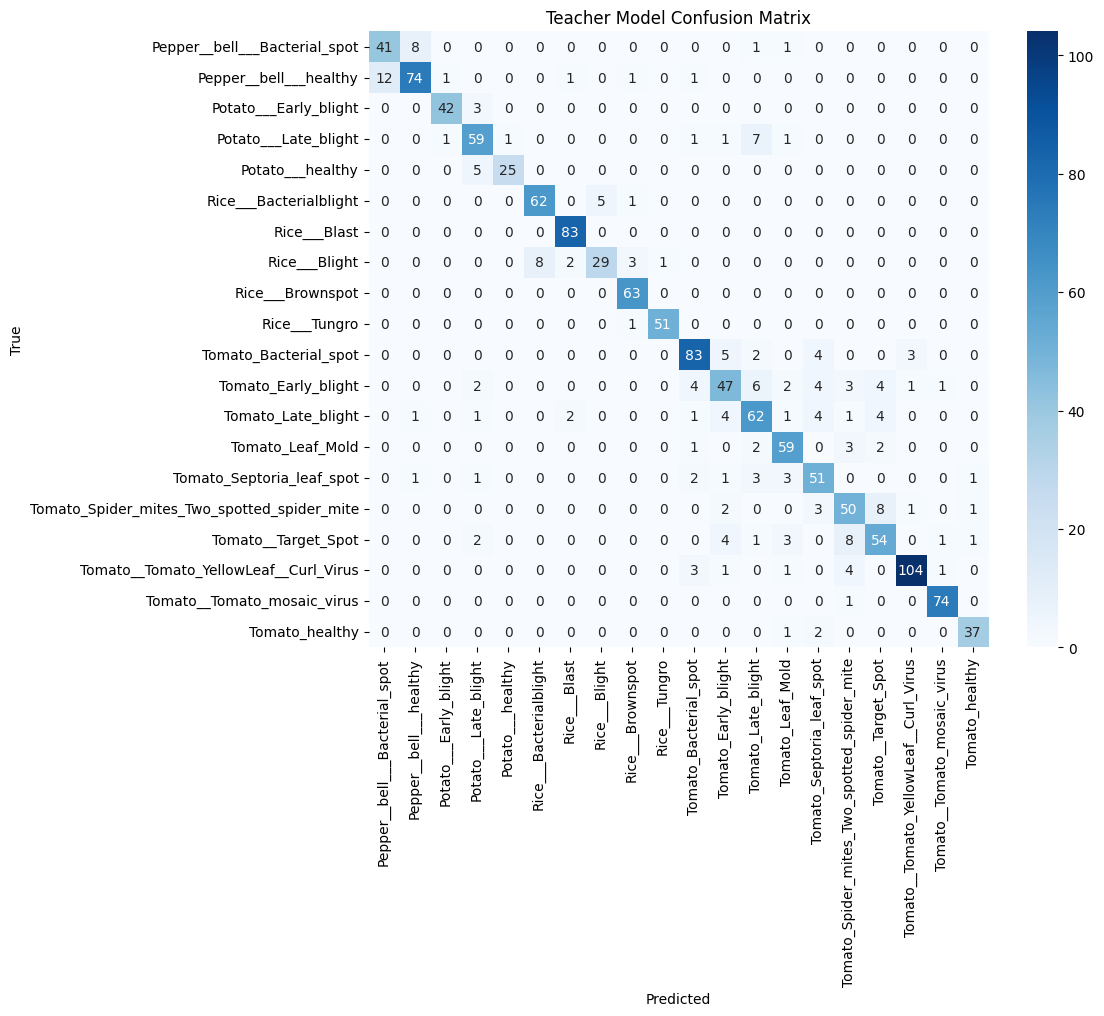

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


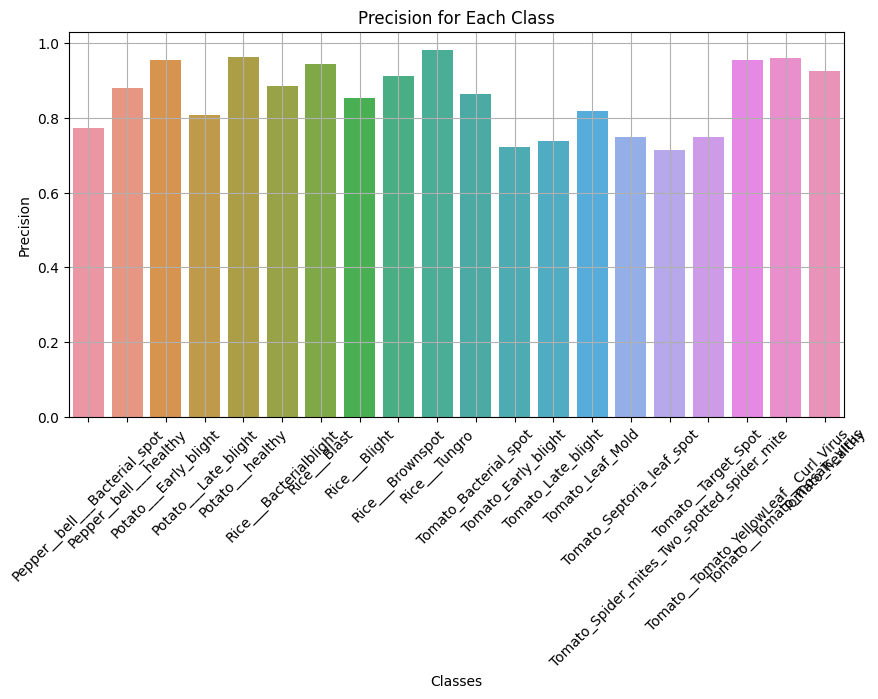

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


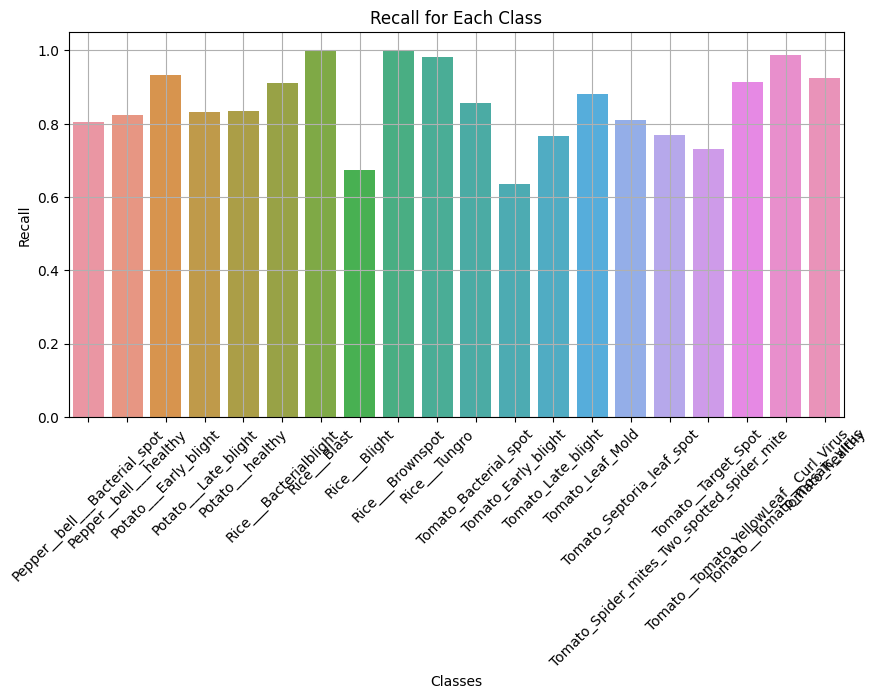

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


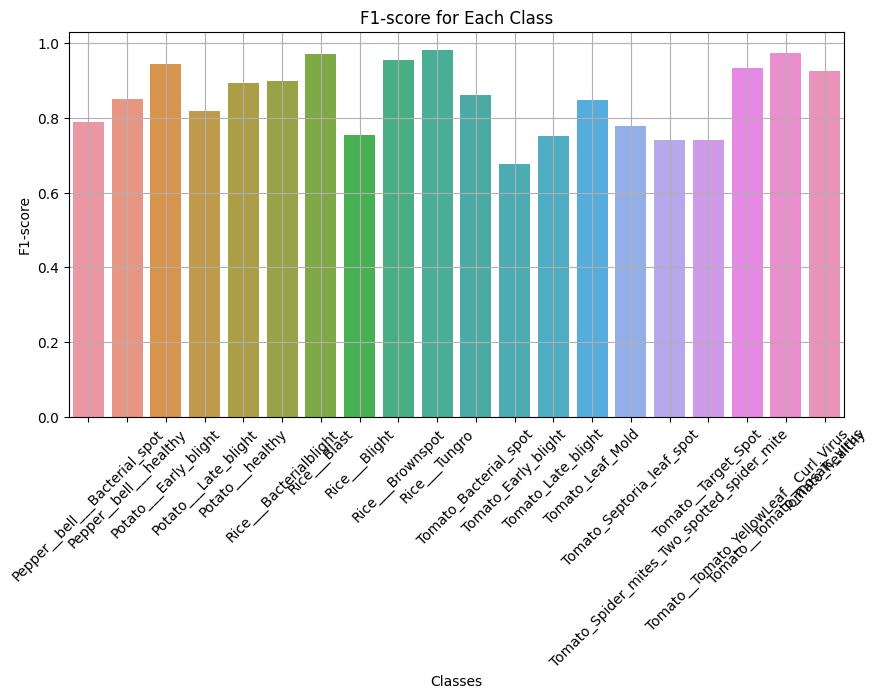

In [16]:
def evaluate_model(model, dataloader, class_names):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            print(type(outputs))  # Check if it's a tuple
            print(len(outputs))   # If it's a tuple, check its length

            # If outputs is a tuple, extract the first element
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())  # Fix .device() → .cpu()
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    acc = accuracy_score(all_labels, all_preds)
    
    print(f'Accuracy: {acc:.4f}')
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

    return acc, cm, cr



teacher_test_acc, teacher_test_cm, teacher_test_cr = evaluate_model(teacher_model, test_loader, class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(teacher_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Teacher Model Confusion Matrix')
plt.show()

def plot_classification_report(cr):
    metrics = ['precision', 'recall', 'f1-score']
    classes = list(cr.keys())[:-3]
    for metric in metrics:
        scores = [cr[cls][metric] for cls in classes]
        plt.figure(figsize=(10, 5))
        sns.barplot(x=classes, y=scores)
        plt.title(f'{metric.capitalize()} for Each Class')
        plt.xlabel('Classes')
        plt.ylabel(metric.capitalize())
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

plot_classification_report(teacher_test_cr)


In [17]:
# #student
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# student_model = student_model.to(device)

# criterion = nn.CrossEntropyLoss()
# student_optimizer = optim.Adam(student_model.parameters(), lr=0.001)


In [18]:
# # student

# class EarlyStopping:
#     def __init__(self, patience=7, verbose=False):
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_score = None
#         self.early_stop = False
#         self.val_loss_min = np.Inf

#     def __call__(self, val_loss, model):
#         score = -val_loss

#         if self.best_score is None:
#             self.best_score = score
#             self.save_checkpoint(val_loss, model)
#         elif score < self.best_score:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_score = score
#             self.save_checkpoint(val_loss, model)
#             self.counter = 0

#     def save_checkpoint(self, val_loss, model):
#         if self.verbose:
#             print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
#         torch.save(model.state_dict(), 'student_yolo_checkpoint.pt')
#         self.val_loss_min = val_loss

# early_stopping = EarlyStopping(patience=8, verbose=True)

# def train_student(model, criterion, optimizer, num_epochs=50):
#     train_loss_history = []
#     val_loss_history = []
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch}/{num_epochs - 1}')
#         print('-' * 10)

#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()
#                 dataloader = train_loader
#             else:
#                 model.eval()
#                 dataloader = val_loader

#             running_loss = 0.0
#             running_corrects = 0

#             for inputs, labels in dataloader:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 optimizer.zero_grad()

#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     # print(f"Type of outputs: {type(outputs)}")
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / len(dataloader.dataset)
#             epoch_acc = running_corrects.double() / len(dataloader.dataset)

#             print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#             if phase == 'val':
#                 val_loss_history.append(epoch_loss)
#                 early_stopping(epoch_loss, model)

#                 if early_stopping.early_stop:
#                     print("Early stopping")
#                     model.load_state_dict(torch.load('student_yolo_checkpoint.pt'))
#                     return model, train_loss_history, val_loss_history
#             else:
#                 train_loss_history.append(epoch_loss)

#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     print(f'Best val Acc: {best_acc:4f}')

#     model.load_state_dict(best_model_wts)
#     return model, train_loss_history, val_loss_history

# student_model, student_train_loss_history, student_val_loss_history = train_student(student_model, criterion, student_optimizer, num_epochs=50)


In [19]:
# # Loading saved student model

# import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load the saved model
# checkpoint = torch.load("/kaggle/input/checkpoints/student_yolo_checkpoint.pt", map_location=device)

# # If you have the model class defined, initialize it
# # model = student_model()  # Replace with your actual model class
# student_model.load_state_dict(checkpoint)  # Load model weights
# student_model.to(device)  # Move model to the correct device
# student_model.eval()  # Set model to evaluation mode

In [20]:
# def evaluate_model(model, dataloader, class_names):
#     model.eval()
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for inputs, labels in dataloader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)

#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     cm = confusion_matrix(all_labels, all_preds)
#     cr = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
#     acc = accuracy_score(all_labels, all_preds)
    
#     print(f'Accuracy: {acc:.4f}')
#     print("Confusion Matrix:\n", cm)
#     print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

#     return acc, cm, cr


# student_test_acc, student_test_cm, student_test_cr = evaluate_model(student_model, test_loader, class_names)

# plt.figure(figsize=(10, 8))
# sns.heatmap(student_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Student Model Confusion Matrix (Without Distillation)')
# plt.show()

# def plot_classification_report(cr):
#     metrics = ['precision', 'recall', 'f1-score']
#     classes = list(cr.keys())[:-3]
#     for metric in metrics:
#         scores = [cr[cls][metric] for cls in classes]
#         plt.figure(figsize=(10, 5))
#         sns.barplot(x=classes, y=scores)
#         plt.title(f'{metric.capitalize()} for Each Class')
#         plt.xlabel('Classes')
#         plt.ylabel(metric.capitalize())
#         plt.xticks(rotation=45)
#         plt.grid(True)
#         plt.show()

# plot_classification_report(student_test_cr)


In [21]:
from torchinfo import summary

# Replace torchsummary with torchinfo
student_model_size = sum(p.numel() for p in student_model.parameters() if p.requires_grad)
print(f'Student Model Size: {student_model_size} parameters')

summary(student_model, input_size=(16, 3, 640, 640))  # Works with tensor inputs

Student Model Size: 545908 parameters


Layer (type:depth-idx)                                            Output Shape              Param #
YOLO                                                              [16, 20]                  --
├─DarkNet: 1-1                                                    [16, 64, 80, 80]          --
│    └─Sequential: 2-1                                            [16, 8, 320, 320]         --
│    │    └─Conv: 3-1                                             [16, 8, 320, 320]         232
│    └─Sequential: 2-2                                            [16, 32, 160, 160]        --
│    │    └─Conv: 3-2                                             [16, 16, 160, 160]        1,184
│    │    └─CSP: 3-3                                              [16, 32, 160, 160]        1,720
│    └─Sequential: 2-3                                            [16, 64, 80, 80]          --
│    │    └─Conv: 3-4                                             [16, 32, 80, 80]          9,280
│    │    └─CSP: 3-5               

In [22]:
# Loading saved stuednt model

# import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load the saved model
# checkpoint = torch.load("/kaggle/working/student_yolo_checkpoint.pt", map_location=device)

# # If you have the model class defined, initialize it
# # model = student_model()  # Replace with your actual model class
# student_model.load_state_dict(checkpoint)  # Load model weights
# student_model.to(device)  # Move model to the correct device
# student_model.eval()  # Set model to evaluation mode

# Applying Knowledge Distillation

In [23]:
# # Loading saved teacher model

# import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load the saved model
# checkpoint = torch.load("/kaggle/input/checkpoints/teacher_yolo_checkpoint.pt", map_location=device)

# # If you have the model class defined, initialize it
# teacher_model = yolo_v11_n(num_classes = 20)  # Replace with your actual model class
# teacher_model.load_state_dict(checkpoint)  # Load model weights
# teacher_model.to(device)  # Move model to the correct device
# teacher_model.eval()  # Set model to evaluation mode

In [24]:
# class EarlyStopping:
#     def __init__(self, patience=8, verbose=False):
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_score = None
#         self.early_stop = False
#         self.val_loss_min = np.Inf

#     def __call__(self, val_loss, model):
#         score = -val_loss

#         if self.best_score is None:
#             self.best_score = score
#             self.save_checkpoint(val_loss, model)
#         elif score < self.best_score:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_score = score
#             self.save_checkpoint(val_loss, model)
#             self.counter = 0

#     def save_checkpoint(self, val_loss, model):
#         if self.verbose:
#             print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
#         torch.save(model.state_dict(), 'distill_yolo_checkpoint.pt')
#         self.val_loss_min = val_loss

In [25]:
#student
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
student_model = student_model.to(device)

criterion = nn.CrossEntropyLoss()
student_optimizer = optim.Adam(student_model.parameters(), lr=0.001)

In [26]:
import torch
import os

class EarlyStopping:
    def __init__(self, patience=100, verbose=False, checkpoint_path="distill_yolo_checkpoint.pt"):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.checkpoint_path = os.path.join('/kaggle/working/', checkpoint_path)

    def __call__(self, val_loss, model, optimizer, epoch, best_acc):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch, best_acc)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch, best_acc)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer, epoch, best_acc):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving checkpoint...')

        checkpoint = {
            'epoch': epoch,  
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc
        }
        torch.save(checkpoint, self.checkpoint_path)
        self.val_loss_min = val_loss


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

class DistillationLoss(nn.Module):
    def __init__(self, temperature=2.0, alpha=0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        ce_loss = self.criterion(student_logits, labels)
        distillation_loss = nn.KLDivLoss()(
            F.log_softmax(student_logits / self.temperature, dim=1),
            F.softmax(teacher_logits / self.temperature, dim=1)
        ) * (self.temperature ** 2)
        
        loss = self.alpha * ce_loss + (1 - self.alpha) * distillation_loss
        return loss

    
def train_student_model_with_distillation(teacher_model, student_model, criterion, optimizer, num_epochs=100):
    train_loss_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(student_model.state_dict())
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=100, verbose=True)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                student_model.train()
                teacher_model.eval()
                dataloader = train_loader
            else:
                student_model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    student_outputs = student_model(inputs)
                    with torch.no_grad():
                        teacher_outputs = teacher_model(inputs)
                        # if isinstance(teacher_outputs, tuple):  # Fix tuple issue
                        #     teacher_outputs = teacher_outputs[0]

                    loss = criterion(student_outputs, teacher_outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(student_outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                val_loss_history.append(epoch_loss)
                early_stopping(epoch_loss, student_model, optimizer, epoch=epoch, best_acc=best_acc)

                if early_stopping.early_stop:
                    print("Early stopping")
                    torch.save(student_model.state_dict(), 'distill_yolo_checkpoint.pt')
                    student_model.load_state_dict(torch.load('distill_yolo_checkpoint.pt'))
                    return student_model, train_loss_history, val_loss_history
            else:
                train_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(student_model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')

    student_model.load_state_dict(best_model_wts)
    return student_model, train_loss_history, val_loss_history



criterion = DistillationLoss(temperature=2.0, alpha=0.5)

student_model, student_train_loss_history, student_val_loss_history = train_student_model_with_distillation(
    teacher_model, student_model, criterion, student_optimizer, num_epochs=100
)


Epoch 0/99
----------


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3369: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


train Loss: 1.6751 Acc: 0.0985
val Loss: 1.4393 Acc: 0.1967
Validation loss decreased (inf --> 1.439305). Saving checkpoint...

Epoch 1/99
----------
train Loss: 1.3332 Acc: 0.2492
val Loss: 1.3367 Acc: 0.2093
Validation loss decreased (1.439305 --> 1.336718). Saving checkpoint...

Epoch 2/99
----------
train Loss: 1.1243 Acc: 0.3667
val Loss: 0.9842 Acc: 0.4495
Validation loss decreased (1.336718 --> 0.984198). Saving checkpoint...

Epoch 3/99
----------
train Loss: 0.9757 Acc: 0.4464
val Loss: 0.8674 Acc: 0.4632
Validation loss decreased (0.984198 --> 0.867449). Saving checkpoint...

Epoch 4/99
----------
train Loss: 0.8778 Acc: 0.5032
val Loss: 0.8328 Acc: 0.5011
Validation loss decreased (0.867449 --> 0.832811). Saving checkpoint...

Epoch 5/99
----------
train Loss: 0.8000 Acc: 0.5395
val Loss: 0.7582 Acc: 0.5505
Validation loss decreased (0.832811 --> 0.758211). Saving checkpoint...

Epoch 6/99
----------
train Loss: 0.7302 Acc: 0.5893
val Loss: 0.6667 Acc: 0.6055
Validation loss

# Classification Report after distillation

<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torch.Tensor'>
32
<class 'torc

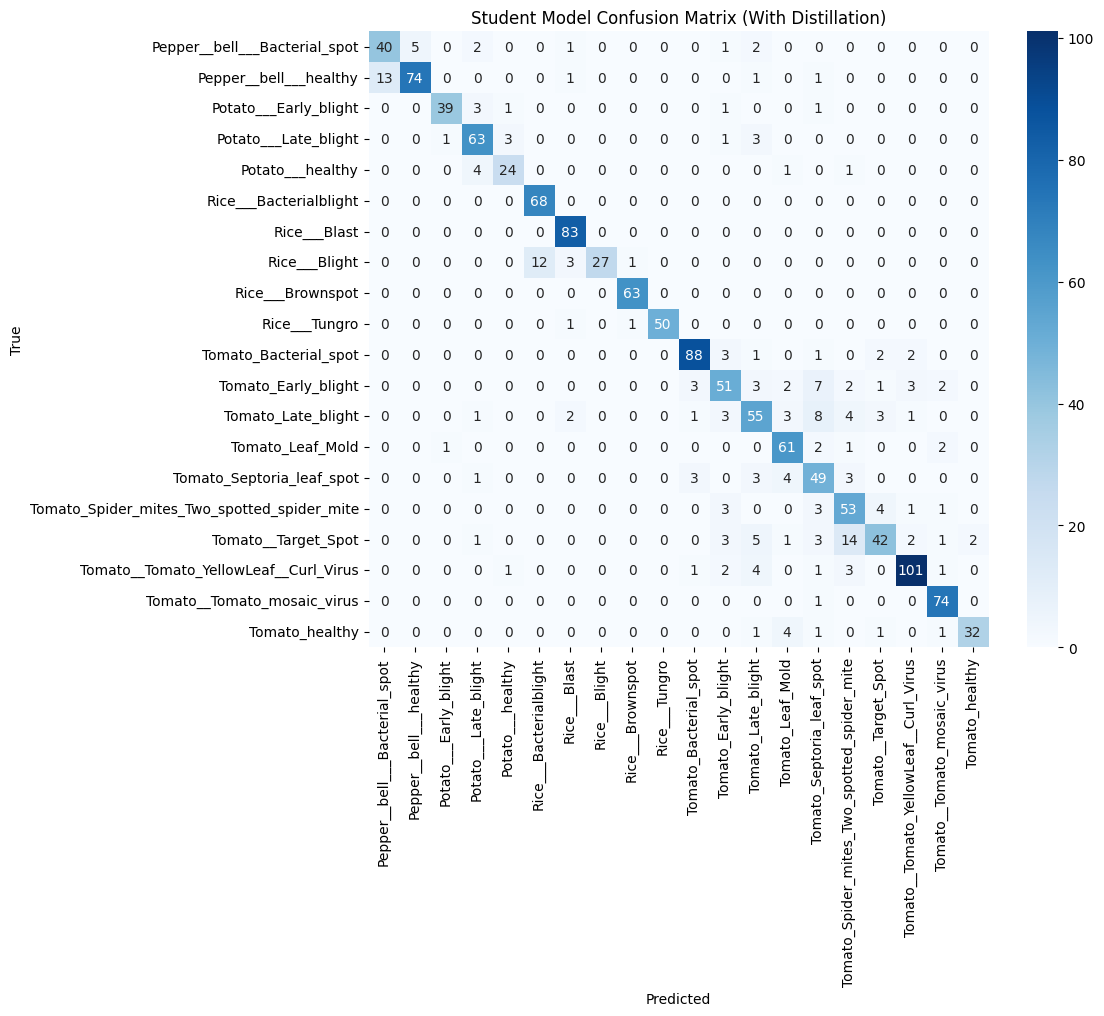

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


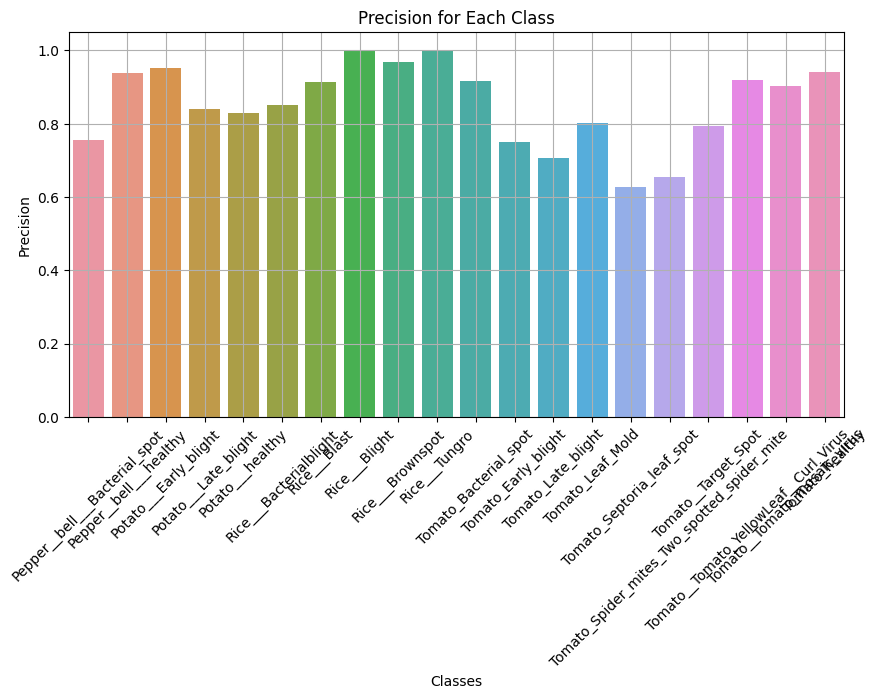

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


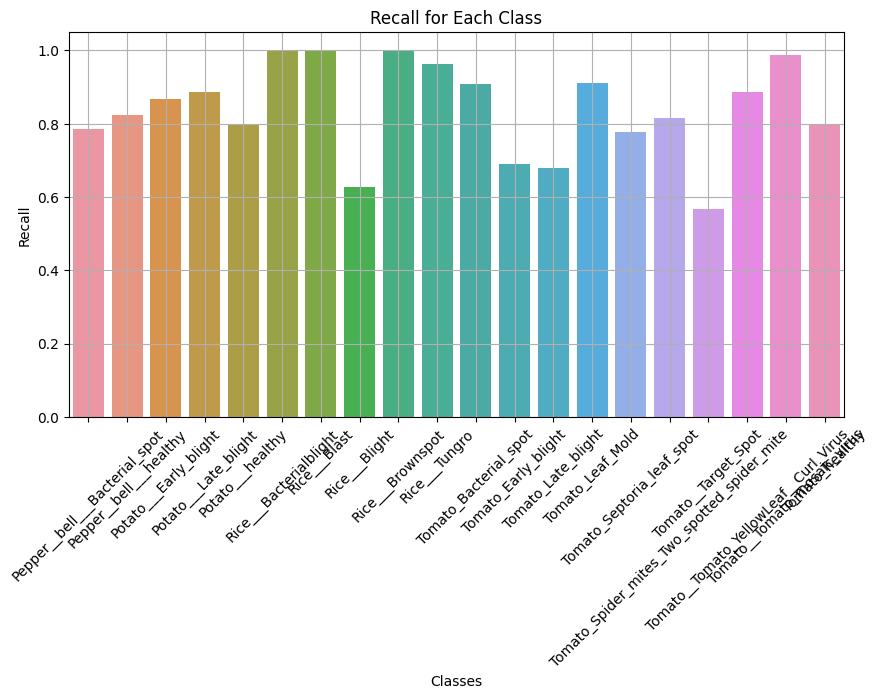

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


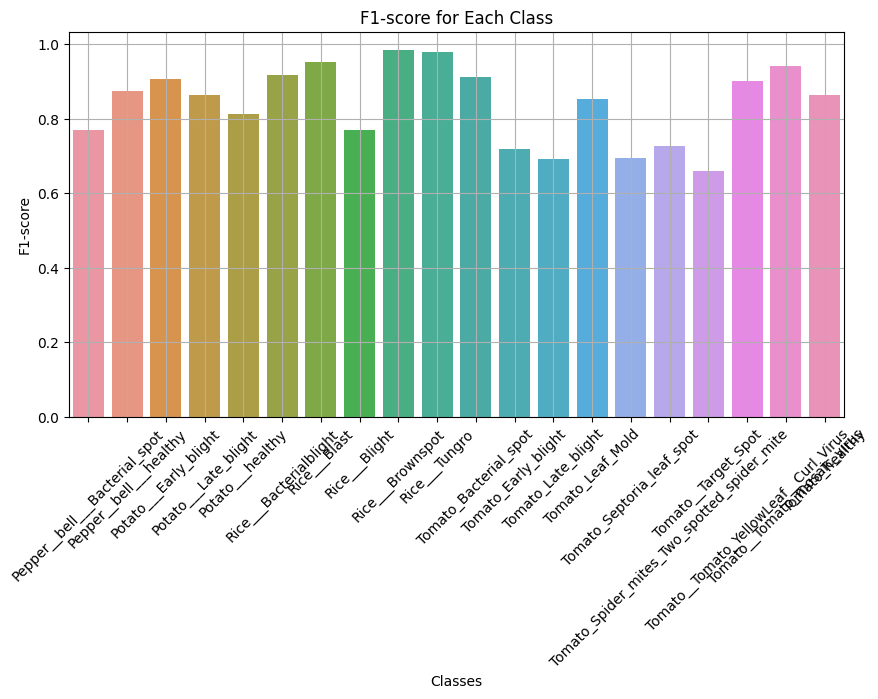

In [28]:
student_test_acc, student_test_cm, student_test_cr = evaluate_model(student_model, test_loader, class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(student_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Student Model Confusion Matrix (With Distillation)')
plt.show()

plot_classification_report(student_test_cr)

# Comparison between teacher and student(after distillation)

Teacher Model Size: 2164308 parameters
Student Model Size: 545908 parameters


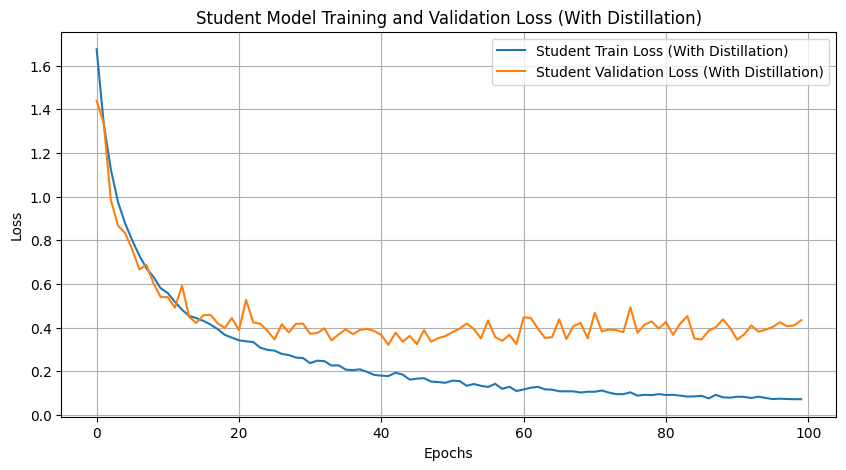

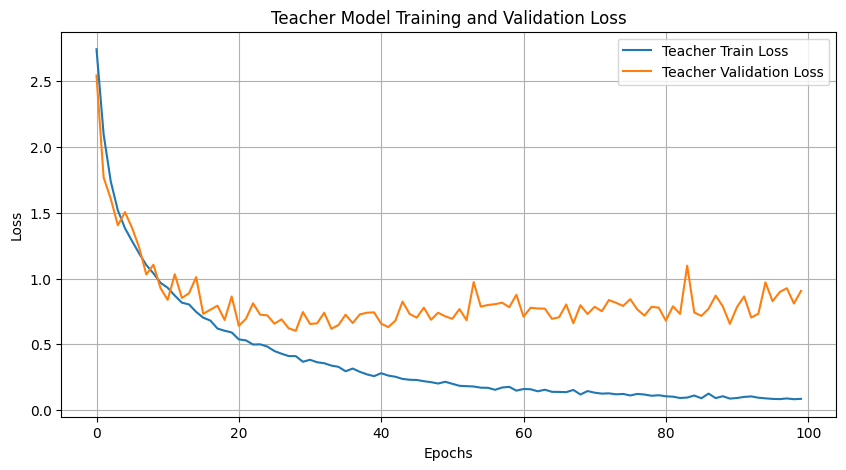

In [29]:
print(f'Teacher Model Size: {teacher_model_size} parameters')
print(f'Student Model Size: {student_model_size} parameters')

plt.figure(figsize=(10, 5))
plt.plot(range(len(student_train_loss_history)), student_train_loss_history, label='Student Train Loss (With Distillation)')
plt.plot(range(len(student_val_loss_history)), student_val_loss_history, label='Student Validation Loss (With Distillation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Student Model Training and Validation Loss (With Distillation)')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(range(len(teacher_train_loss_history)), teacher_train_loss_history, label='Teacher Train Loss')
plt.plot(range(len(teacher_val_loss_history)), teacher_val_loss_history, label='Teacher Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Teacher Model Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()